# IE437 HW3 – Data-Driven Design Optimization

Got help from AI writing the Readme, and code cleanup.

# Overall flow

## 1. Data loading & EDA
- Load `log.csv`.
- Inspect the distribution of $A..E$ and `score`.
- Draw a correlation heatmap similar to the one in the HW3 PDF.

---

## 2. Surrogate backbones

### **MLP baseline** (PyTorch)
A simple 2-layer network $f_{\text{MLP}}(x)$.

### **GP baseline**
Gaussian Process with ARD RBF kernel (`GaussianProcessRegressor`).

---

## 3. NeMO / COMs / RoMA-like surrogates

We use a shared MLP backbone $z(x) = f_{\text{back}}(x;\theta_{\text{back}})$ and attach different heads / losses, matching the PDF.

---

# NeMO (Neural Moment)

The head outputs mean and log-variance **on normalized target scale**:

$$
[\mu_{\text{norm}}(x),\ \log v_{\text{norm}}(x)]
= W_{\text{NeMO}}\,z(x) + b_{\text{NeMO}}.
$$

Predictive std:

$$
\sigma_{\text{norm}}(x) = \exp\!\left(\tfrac12 \log v_{\text{norm}}(x)\right).
$$

Gaussian NLL loss:

$$
L_{\text{NeMO}}
= -\sum_i
\log N\!\left(
    y_{i,\text{norm}}
    \mid
    \mu_{\text{norm}}(x_i),
    v_{\text{norm}}(x_i)
\right).
$$

Conservative objective (LCB):

$$
J_{\text{NeMO}}(x) = \mu(x) - \kappa\,\sigma(x).
$$

---

# COMs (Conservative Model)

Scalar mean head $\hat y(x)$.

Training loss:

$$
L_{\text{COMs}}
= \text{MSE}(\hat y(x), y)
+ \alpha\,
  \mathbb{E}_{\delta}
  \left[
    \max\bigl(0,\ \hat y(x+\delta)-\hat y(x)\bigr)
  \right].
$$

Judge:

- Local adversarial predictions: $\mu_{\text{adv},k}(x)=\hat y(x+\delta_k)$  
- Worst-case local mean:

$$
\mu_{\text{COMs}}(x)=\min_k \mu_{\text{adv},k}(x)
$$

- Risk proxy:

$$
\sigma_{\text{COMs}}(x)
= \left[\hat y(x)-\mu_{\text{COMs}}(x)\right]_+
$$

- LCB:

$$
\text{LCB}_{\text{COMs}}(x)
= \mu_{\text{COMs}}(x) - \kappa\,\sigma_{\text{COMs}}(x).
$$

---

# RoMA (Robustness-Aware Model)

Scalar mean head $\hat y(x)$.

Training loss:

$$
L_{\text{RoMA}}
=
\text{MSE}(\hat y(x), y)
+
\beta_{\text{smooth}}
\,
\mathbb{E}_{\epsilon}
\left[
    (\hat y(x+\epsilon) - \hat y(x))^2
\right].
$$

Judge:

- Local mean:

$$
\mu_{\text{RoMA}}(x)
= \mathbb{E}_k [\,\hat y(x+\epsilon_k)\,]
$$

- Local variance:

$$
\sigma_{\text{RoMA}}(x)
= \sqrt{\mathrm{Var}_k[\hat y(x+\epsilon_k)]}
$$

- LCB:

$$
\text{LCB}_{\text{RoMA}}(x)
= \mu_{\text{RoMA}}(x)
  - \kappa\,\sigma_{\text{RoMA}}(x).
$$

---

# 4. GP backbone and GP-based NeMO / COMs / RoMA

Using GP posterior formulas:

$$
\mu(x) = k(x, X)\,(K + \sigma_\varepsilon^2 I)^{-1} y,
$$

$$
\sigma^2(x)
= k(x,x)
- k(x,X)\,(K + \sigma_\varepsilon^2 I)^{-1} k(x,X)^\top.
$$

These GP mean/variance plug into NeMO/COMs/RoMA judges identically:

- GP-NeMO LCB: $\mu - \kappa\sigma$
- GP-COMs LCB (via sampling)
- GP-RoMA LCB (via local variance)

DIRECT is used for global optimization.

---

# 5. Optimization with trajectories and DIRECT

We implement a generic function `run_ascent_with_traj` doing **finite-difference gradient ascent** over $[0,1]^5$ on any black-box $J(x)$.

We run ascent on:

- MLP mean
- NeMO-LCB
- RoMA-LCB
- COMs-LCB

GP baseline is also optimized via this ascent (to highlight local trapping).

For GP-NeMO, GP-RoMA, GP-COMs: we additionally run **DIRECT** for global optimization.

---

# 6. Flowline, frontier and decision analysis

We collect candidates from all methods.

For each candidate under each judge $m$:

- Posterior mean $\mu_m(x)$
- Uncertainty $\sigma_m(x)$
- LCB:

$$
\mathrm{LCB}_m(x) = \mu_m(x) - \kappa\,\sigma_m(x)
$$

- Expected Improvement (EI):
  
$$
z=\frac{\mu(x)-y^*}{\sigma(x)},
$$

$$
\mathrm{EI}(x)
=
(\mu(x)-y^*)\Phi(z)
+
\sigma(x)\phi(z)
$$

OOD distance:

$$
d(x) = \min_i \| x - x_i^{\text{train}} \|_2.
$$

Risk filtering:
- Keep only candidates with $d(x)\le 0.15$ and high LCB.

We then:
- Plot risk–reward clouds
- Plot efficient frontiers $(\sigma_m(x),\mu_m(x))$
- Choose risk-neutral (max mean) and risk-averse (min std) points
- Produce pie-chart timetables
- Export top-5 candidates per model to Excel

---

Below we implement everything step-by-step.


In [ ]:
# Cell 1 – Imports and global configuration

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

from scipy.optimize import direct, Bounds
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Pretty plotting defaults
sns.set(style="whitegrid")


Using device: cuda


## 1. Load data & basic EDA (heatmap)

We assume the HW3 offline log is saved as **`log.csv`** in the current working directory. The columns should be:
- `A, B, C, D, E`: proportion of time spent on each activity.
- `score`: exam score.

We:
- Load the data.
- Inspect basic statistics.
- Draw a **correlation heatmap** similar to the one in the PDF to understand which activities correlate with performance.


Data shape: (9992, 6)


,A,B,C,D,E,score
0,0.185171,0.012469,0.643883,0.000518,0.706477,64.948380
1,0.109382,0.264447,0.830440,0.936024,0.152748,67.864240
2,0.879817,0.268302,0.687127,0.694333,0.049413,72.356650
3,0.015239,0.792621,0.065918,0.493001,0.010857,69.130690
4,0.021096,0.480832,0.964605,0.124905,0.399937,65.814804



Basic statistics:


,A,B,C,D,E,score
count,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000
mean,0.498985,0.498149,0.494426,0.495300,0.498725,71.645244
std,0.291844,0.289512,0.289011,0.289082,0.289978,4.333470
min,0.000064,0.000010,0.000397,0.000126,0.000233,62.944380
25%,0.244372,0.247665,0.241093,0.242532,0.245855,68.460217
50%,0.499789,0.498503,0.491682,0.494536,0.497319,70.780107
75%,0.754511,0.749839,0.747202,0.743745,0.750852,74.079871
max,0.999860,0.999969,0.999882,0.999996,0.999987,89.830920


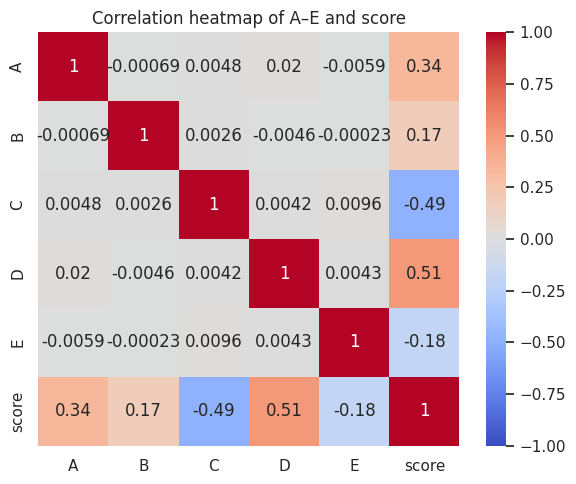

In [ ]:
# Cell 2 – Load offline log and draw heatmap

LOG_PATH = "log.csv"  # change this if your file is elsewhere

df = pd.read_csv(LOG_PATH)
print("Data shape:", df.shape)
display(df.head())

features = ["A", "B", "C", "D", "E"]
target = "score"

print("\nBasic statistics:")
display(df[features + [target]].describe())

# Correlation heatmap
plt.figure(figsize=(6, 5))
corr = df[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap of A–E and score")
plt.tight_layout()
plt.show()


## 2. Train/valid/test split and normalization

We split the data into train / validation / test (80% / 10% / 10%) and **standardize the target**:
\[
y_{\text{norm}} = \frac{y - \mu_y}{\sigma_y}.
\]
This is the scale on which the MLP losses are defined. When we report scores or build acquisition functions, we always **map back** to the original score scale.


In [ ]:
# Cell 3 – Split and normalize (no random shuffle)

X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# 80% train, 20% temp (valid+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
# temp(20%)를 다시 10%/10%로
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print("Shapes:")
print("  train:", X_train.shape, y_train.shape)
print("  valid:", X_valid.shape, y_valid.shape)
print("  test :", X_test.shape,  y_test.shape)

# Target normalization (fit on train only)
# y_mean = 0
# y_std = 1
y_mean = y_train.mean()
y_std = y_train.std()
print("\nTarget mean/std (train):", y_mean, y_std)

y_train_norm = (y_train - y_mean) / y_std
y_valid_norm = (y_valid - y_mean) / y_std
y_test_norm  = (y_test  - y_mean) / y_std

def make_loader(X_, y_norm_, batch_size=128, shuffle=True):
    xt = torch.from_numpy(X_).float().to(device)
    yt = torch.from_numpy(y_norm_).float().to(device).unsqueeze(-1)
    ds = TensorDataset(xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train_norm, shuffle=True)
val_loader   = make_loader(X_valid, y_valid_norm, shuffle=False)
test_loader  = make_loader(X_test,  y_test_norm,  shuffle=False)


Shapes:
  train: (7993, 5) (7993,)
  valid: (999, 5) (999,)
  test : (1000, 5) (1000,)

Target mean/std (train): 71.62668 4.3292623


## 3. MLP backbone and NeMO / COMs / RoMA surrogates

We implement the **shared MLP backbone** and three heads / loss functions:

- `vanilla` MLP: scalar output, trained with MSE on normalized scores.
- `NeMO`: 2‑dimensional head outputting $$[\mu_{\text{norm}}, \log v_{\text{norm}}]$$
 with Gaussian NLL.
- `RoMA`: scalar head with MSE + local smoothness penalty.
- `COMs`: scalar head with MSE + adversarial local worst‑case penalty.

We also provide helper functions to evaluate each model on the original score scale.


In [ ]:
class AdvancedSurrogateMLP(nn.Module):
    """Simple 2‑layer MLP.

    out_dim = 1 -> scalar output (vanilla / RoMA / COMs)
    out_dim = 2 -> [mu_norm, log_var_norm] (NeMO)
    """
    def __init__(self, input_dim=5, hidden_dim=64, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)


def evaluate_mlp_regressor(model, loader, nemo_like=False):
    """RMSE / R^2 on original score scale."""
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb_norm in loader:
            out = model(xb)
            if nemo_like:
                mu_norm = out[..., 0:1]
                mu = mu_norm * y_std + y_mean
            else:
                mu = out * y_std + y_mean
            y_true = yb_norm * y_std + y_mean
            preds.append(mu.cpu().numpy())
            trues.append(y_true.cpu().numpy())

    preds = np.concatenate(preds, axis=0).ravel()
    trues = np.concatenate(trues, axis=0).ravel()
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2   = r2_score(trues, preds)
    return rmse, r2


def train_vanilla_mlp(training_step=10000, lr=1e-3, patience=20, min_delta=1e-3, validation_interval=1000):
    model = AdvancedSurrogateMLP(input_dim=5, hidden_dim=64, out_dim=1).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_state = None
    best_val = float("inf")
    patience_ctr = 0
    train_losses_history_interval = []

    for step in range(1, training_step + 1):
        model.train()
        # Simulate batch loading from X_train, y_train_norm
        idx = torch.randint(0, len(X_train), size=(train_loader.batch_size,))
        xb = torch.from_numpy(X_train[idx]).float().to(device)
        yb_norm = torch.from_numpy(y_train_norm[idx]).float().to(device).unsqueeze(-1)

        opt.zero_grad()
        out = model(xb)
        loss = ((out - yb_norm)**2).mean()
        loss.backward()
        opt.step()
        train_losses_history_interval.append(loss.item())

        if step % validation_interval == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for val_xb, val_yb_norm in val_loader:
                    out = model(val_xb)
                    loss = ((out - val_yb_norm)**2).mean()
                    val_losses.append(loss.item())

            val_rmse, val_r2 = evaluate_mlp_regressor(model, val_loader, nemo_like=False)
            mean_train_interval_loss = np.mean(train_losses_history_interval)
            mean_val_loss = np.mean(val_losses)
            print(f"[Vanilla] Step {step:5d}  train_loss={mean_train_interval_loss:.4f}  val_loss={mean_val_loss:.4f}  val_RMSE={val_rmse:.3f}  val_R2={val_r2:.3f}")
            train_losses_history_interval = [] # Reset for next interval

            if mean_val_loss + min_delta < best_val:
                best_val = mean_val_loss
                best_state = model.state_dict()
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    print("[Vanilla] Early stopping")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def train_nemo_mlp(training_step=10000, lr=1e-3, patience=20, min_delta=1e-3, validation_interval=1000):
    """NeMO‑style MLP: [mu_norm, log_var_norm] with Gaussian NLL."""
    model = AdvancedSurrogateMLP(input_dim=5, hidden_dim=64, out_dim=2).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_state = None
    best_val = float("inf")
    patience_ctr = 0
    train_losses_history_interval = []

    for step in range(1, training_step + 1):
        model.train()
        # Simulate batch loading from X_train, y_train_norm
        idx = torch.randint(0, len(X_train), size=(train_loader.batch_size,))
        xb = torch.from_numpy(X_train[idx]).float().to(device)
        yb_norm = torch.from_numpy(y_train_norm[idx]).float().to(device).unsqueeze(-1)

        opt.zero_grad()
        out = model(xb)
        mu_norm = out[..., 0]
        log_var_norm = out[..., 1]
        var_norm = torch.exp(log_var_norm)
        # Gaussian NLL on normalized scale
        nll = 0.5 * (torch.log(2 * torch.tensor(np.pi, device=device) * var_norm) + (yb_norm.squeeze(-1) - mu_norm)**2 / var_norm)
        loss = nll.mean()
        loss.backward()
        opt.step()
        train_losses_history_interval.append(loss.item())

        if step % validation_interval == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for val_xb, val_yb_norm in val_loader:
                    out = model(val_xb)
                    mu_norm = out[..., 0]
                    log_var_norm = out[..., 1]
                    var_norm = torch.exp(log_var_norm)
                    nll = 0.5 * (torch.log(2 * torch.tensor(np.pi, device=device) * var_norm) + (val_yb_norm.squeeze(-1) - mu_norm)**2 / var_norm)
                    val_losses.append(nll.mean().item())

            val_rmse, val_r2 = evaluate_mlp_regressor(model, val_loader, nemo_like=True)
            mean_train_interval_loss = np.mean(train_losses_history_interval)
            mean_val_loss = np.mean(val_losses)
            print(f"[NeMO]    Step {step:5d}  train_NLL={mean_train_interval_loss:.4f}  val_NLL={mean_val_loss:.4f}  val_RMSE={val_rmse:.3f}  val_R2={val_r2:.3f}")
            train_losses_history_interval = []

            if mean_val_loss + min_delta < best_val:
                best_val = mean_val_loss
                best_state = model.state_dict()
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    print("[NeMO] Early stopping")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def train_roma_mlp(training_step=10000, lr=1e-3, beta_smooth=0.5, noise_scale=0.05,
                   patience=20, min_delta=1e-3, validation_interval=1000):
    """RoMA‑style MLP: MSE + local smoothness penalty.

    L = MSE + beta_smooth * E[(f(x + noise) - f(x))^2].
    """
    model = AdvancedSurrogateMLP(input_dim=5, hidden_dim=64, out_dim=1).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_state = None
    best_val = float("inf")
    patience_ctr = 0
    train_losses_history_interval = []

    for step in range(1, training_step + 1):
        model.train()
        # Simulate batch loading from X_train, y_train_norm
        idx = torch.randint(0, len(X_train), size=(train_loader.batch_size,))
        xb = torch.from_numpy(X_train[idx]).float().to(device)
        yb_norm = torch.from_numpy(y_train_norm[idx]).float().to(device).unsqueeze(-1)

        opt.zero_grad()
        y_pred = model(xb)
        noise = noise_scale * torch.randn_like(xb)
        x_noisy = (xb + noise).clamp(0, 1)
        y_noisy = model(x_noisy)

        mse = ((y_pred - yb_norm)**2).mean()
        smooth_penalty = ((y_noisy - y_pred.detach())**2).mean()
        loss = mse + beta_smooth * smooth_penalty
        loss.backward()
        opt.step()
        train_losses_history_interval.append(loss.item())

        if step % validation_interval == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for val_xb, val_yb_norm in val_loader:
                    y_pred = model(val_xb)
                    loss = ((y_pred - val_yb_norm)**2).mean()
                    val_losses.append(loss.item())

            val_rmse, val_r2 = evaluate_mlp_regressor(model, val_loader, nemo_like=False)
            mean_train_interval_loss = np.mean(train_losses_history_interval)
            mean_val_loss = np.mean(val_losses)
            print(f"[RoMA]   Step {step:5d}  train_loss={mean_train_interval_loss:.4f}  val_loss={mean_val_loss:.4f}  val_RMSE={val_rmse:.3f}  val_R2={val_r2:.3f}")
            train_losses_history_interval = []

            if mean_val_loss + min_delta < best_val:
                best_val = mean_val_loss
                best_state = model.state_dict()
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    print("[RoMA] Early stopping")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def train_coms_mlp(training_step=10000, lr=1e-3, alpha=0.5, delta=0.1,
                   num_adv_samples=8, patience=20, min_delta=1e-3, validation_interval=1000):
    """COMs‑style MLP: MSE + adversarial local worst‑case penalty.

    L = MSE + alpha * E[max(0, y_adv - y_clean)].
    """
    model = AdvancedSurrogateMLP(input_dim=5, hidden_dim=64, out_dim=1).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_state = None
    best_val = float("inf")
    patience_ctr = 0
    train_losses_history_interval = []

    for step in range(1, training_step + 1):
        model.train()
        # Simulate batch loading from X_train, y_train_norm
        idx = torch.randint(0, len(X_train), size=(train_loader.batch_size,))
        xb = torch.from_numpy(X_train[idx]).float().to(device)
        yb_norm = torch.from_numpy(y_train_norm[idx]).float().to(device).unsqueeze(-1)

        opt.zero_grad()
        y_clean = model(xb)
        mse = ((y_clean - yb_norm)**2).mean()

        adv_vals = []
        for _ in range(num_adv_samples):
            noise = torch.randn_like(xb)
            noise = noise / (noise.norm(dim=1, keepdim=True) + 1e-8)
            noise = noise * delta
            x_adv = (xb + noise).clamp(0, 1)
            y_adv = model(x_adv)
            adv_vals.append(y_adv)
        adv_stack = torch.stack(adv_vals, dim=2)  # (B,1,K)
        y_adv_max = adv_stack.max(dim=2).values  # (B,1)
        cons_penalty = torch.relu(y_adv_max - y_clean).mean()
        loss = mse + alpha * cons_penalty
        loss.backward()
        opt.step()
        train_losses_history_interval.append(loss.item())

        if step % validation_interval == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for val_xb, val_yb_norm in val_loader:
                    y_clean = model(val_xb)
                    loss = ((y_clean - val_yb_norm)**2).mean()
                    val_losses.append(loss.item())

            val_rmse, val_r2 = evaluate_mlp_regressor(model, val_loader, nemo_like=False)
            mean_train_interval_loss = np.mean(train_losses_history_interval)
            mean_val_loss = np.mean(val_losses)
            print(f"[COMs]   Step {step:5d}  train_loss={mean_train_interval_loss:.4f}  val_loss={mean_val_loss:.4f}  val_RMSE={val_rmse:.3f}  val_R2={val_r2:.3f}")
            train_losses_history_interval = []

            if mean_val_loss + min_delta < best_val:
                best_val = mean_val_loss
                best_state = model.state_dict()
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    print("[COMs] Early stopping")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# Forward helpers (MLP) on original score scale

def mlp_mu(model, x_np):
    """Vanilla MLP prediction on original score scale for a single x (np.array shape (5,))."""
    x_t = torch.from_numpy(x_np[None, :]).float().to(device)
    with torch.no_grad():
        y_norm = model(x_t).squeeze(-1)
        mu = y_norm * y_std + y_mean
    return float(mu.item())


def nemo_mlp_mu_sigma(model, x_np):
    """NeMO MLP: returns (mu, sigma) on original scale for a single x."""
    x_t = torch.from_numpy(x_np[None, :]).float().to(device)
    with torch.no_grad():
        out = model(x_t)
        mu_norm = out[..., 0:1]
        log_var_norm = out[..., 1:2]
        sigma_norm = torch.exp(0.5 * log_var_norm)
        mu = mu_norm * y_std + y_mean
        sigma = sigma_norm * y_std
    return float(mu.item()), float(sigma.item())


# Pre‑draw noise directions for RoMA/COMs (deterministic across calls)
NUM_LOCAL_SAMPLES = 20
_noise_dirs = np.random.randn(NUM_LOCAL_SAMPLES, 5).astype(np.float32)
_noise_dirs /= (np.linalg.norm(_noise_dirs, axis=1, keepdims=True) + 1e-8)
_noise_dirs = torch.tensor(_noise_dirs, device=device)  # pre-cast


def roma_mlp_mu_sigma(model, x_np, noise_scale=0.05):
    """RoMA judge from MLP: robust mean and std under Gaussian perturbations."""
    X_noisy = x_np[None, :] + noise_scale * _noise_dirs  # (K,5)

    X_noisy = np.clip(X_noisy, 0.0, 1.0)
    x_t = torch.from_numpy(X_noisy).float().to(device)
    with torch.no_grad():
        y_norm = model(x_t).squeeze(-1)
        y = y_norm * y_std + y_mean
    y_np = y.cpu().numpy()
    mu = y.mean()      # Tensor
    sigma = y.std() + 1e-6  # Tensor
    return mu, sigma



def coms_mlp_mu_sigma(model, x_np, delta=0.10):
    """COMs judge from MLP: local worst‑case mean and a risk proxy."""
    # Clean prediction
    mu_clean = mlp_mu(model, x_np)

    X_adv = x_np[None, :] + delta * _noise_dirs  # use directions as a small sphere
    X_adv = np.clip(X_adv, 0.0, 1.0)
    x_t = torch.from_numpy(X_adv).float().to(device)
    with torch.no_grad():
        y_norm = model(x_t).squeeze(-1)
        y = y_norm * y_std + y_mean
    adv_means = y.cpu().numpy()  # (K,)
    mu_coms = float(adv_means.min())
    sigma_coms = max(1e-6, mu_clean - mu_coms)
    return mu_coms, sigma_coms


### Train the MLP variants

We now train:

- Vanilla MLP baseline.
- NeMO MLP.
- RoMA MLP.
- COMs MLP.

This cell can be somewhat heavy; if needed, you can reduce `num_epochs` to make it faster.


In [ ]:
BATCH = 128
TRANING_STEP = 10000
VAL_INT = 1000
LR = 1e-3

print("\n=== Training vanilla MLP baseline ===")
vanilla_mlp = train_vanilla_mlp(training_step=TRANING_STEP, patience=2, min_delta=1e-10, lr=LR, validation_interval=VAL_INT)

print("\n=== Training NeMO MLP ===")
nemo_mlp = train_nemo_mlp(training_step=TRANING_STEP, patience=2, min_delta=1e-10, lr=LR, validation_interval=VAL_INT)

print("\n=== Training RoMA MLP ===")
roma_mlp = train_roma_mlp(training_step=TRANING_STEP, patience=2, min_delta=1e-10, lr=LR, validation_interval=VAL_INT)

print("\n=== Training COMs MLP ===")
coms_mlp = train_coms_mlp(training_step=TRANING_STEP, patience=2, min_delta=1e-10, lr=LR, validation_interval=VAL_INT)

print("\n=== Final MLP performance (test set) ===")
for name, model, nemo_like in [
    ("Vanilla", vanilla_mlp, False),
    ("NeMO", nemo_mlp, True),
    ("RoMA", roma_mlp, False),
    ("COMs", coms_mlp, False),
]:
    rmse, r2 = evaluate_mlp_regressor(model, test_loader, nemo_like=nemo_like)
    print(f"{name:8s}  test_RMSE={rmse:6.3f}  test_R2={r2:6.3f}")


=== Training vanilla MLP baseline ===
[Vanilla] Step  1000  train_loss=0.0956  val_loss=0.0169  val_RMSE=0.564  val_R2=0.983
[Vanilla] Step  2000  train_loss=0.0135  val_loss=0.0114  val_RMSE=0.462  val_R2=0.988
[Vanilla] Step  3000  train_loss=0.0103  val_loss=0.0097  val_RMSE=0.425  val_R2=0.990
[Vanilla] Step  4000  train_loss=0.0093  val_loss=0.0098  val_RMSE=0.429  val_R2=0.990
[Vanilla] Step  5000  train_loss=0.0089  val_loss=0.0094  val_RMSE=0.420  val_R2=0.990
[Vanilla] Step  6000  train_loss=0.0085  val_loss=0.0090  val_RMSE=0.411  val_R2=0.991
[Vanilla] Step  7000  train_loss=0.0083  val_loss=0.0091  val_RMSE=0.412  val_R2=0.991
[Vanilla] Step  8000  train_loss=0.0081  val_loss=0.0087  val_RMSE=0.402  val_R2=0.991
[Vanilla] Step  9000  train_loss=0.0079  val_loss=0.0105  val_RMSE=0.443  val_R2=0.989
[Vanilla] Step 10000  train_loss=0.0078  val_loss=0.0087  val_RMSE=0.402  val_R2=0.991

=== Training NeMO MLP ===
[NeMO]    Step  1000  train_NLL=-0.3486  val_NLL=-0.7772  val_RM

## 3.1. `run_ascent_with_traj` and PCA visualization (MLP)

We now implement a generic **finite‑difference gradient ascent** routine:

- Domain: \([0,1]^5\).
- Input: a scalar score function \(J(x)\) (e.g., vanilla MLP mean, NeMO‑LCB, RoMA‑LCB, COMs‑LCB).
- Output:
  - Final points for each trial.
  - Final scores.
  - Trajectories (sequence of timetables for each trial).

We then project the offline data and the trajectories into 2D using **PCA** and plot the trajectories to see how each surrogate moves timetables in the design space.


In [ ]:
KAPPA = 1.0
import torch
import numpy as np

# Pre‑draw noise directions for RoMA/COMs (deterministic across calls)
NUM_LOCAL_SAMPLES = 20
_noise_dirs_np = np.random.randn(NUM_LOCAL_SAMPLES, 5).astype(np.float32)
_noise_dirs_np /= (np.linalg.norm(_noise_dirs_np, axis=1, keepdims=True) + 1e-8)
_noise_dirs_torch = torch.tensor(_noise_dirs_np, device=device)  # pre-cast for torch-based models

# ===== Torch-friendly score functions =====
def score_vanilla_mlp_torch(x_torch):
    """Vanilla MLP, input x_torch shape (5,)"""
    x_t = x_torch.unsqueeze(0)  # (1,5)
    y_norm = vanilla_mlp(x_t).squeeze(-1)   # (1,)
    mu = y_norm * y_std + y_mean
    return mu.squeeze()  # scalar tensor

def score_nemo_mlp_lcb_torch(x_torch, kappa=KAPPA):
    """NeMO MLP: returns mu - kappa * sigma"""
    x_t = x_torch.unsqueeze(0)  # (1,5)
    out = nemo_mlp(x_t)         # (1,2)
    mu_norm = out[..., 0:1]
    log_var_norm = out[..., 1:2]
    sigma_norm = torch.exp(0.5 * log_var_norm)
    mu = mu_norm * y_std + y_mean
    sigma = sigma_norm * y_std
    y = mu - kappa * sigma
    return y.squeeze()  # scalar tensor


def score_roma_mlp_lcb_torch(x_torch, kappa=KAPPA, noise_scale=0.05):
    """RoMA MLP: robust mean and std under perturbations (Tensor return)"""
    X_noisy = x_torch.unsqueeze(0) + noise_scale * _noise_dirs_torch
    X_noisy = X_noisy.clamp(0.0, 1.0)

    y_norm = roma_mlp(X_noisy).squeeze(-1)  # (K,)
    y = y_norm * y_std + y_mean  # Tensor 유지

    mu = y.mean()      # Tensor
    sigma = y.std() + 1e-6  # Tensor
    return mu - kappa * sigma  # Tensor 리턴


def score_coms_mlp_lcb_torch(x_torch, kappa=KAPPA, delta=0.1):
    """COMs MLP: worst-case local mean (Tensor return)"""
    # Use vanilla_mlp as a clean prediction reference
    y_clean_norm = vanilla_mlp(x_torch.unsqueeze(0)).squeeze(-1)
    y_clean = y_clean_norm * y_std + y_mean

    X_adv = x_torch.unsqueeze(0) + delta * _noise_dirs_torch
    X_adv = X_adv.clamp(0.0, 1.0)
    y_adv_norm = coms_mlp(X_adv).squeeze(-1)
    y_adv = y_adv_norm * y_std + y_mean  # Tensor (K,)

    mu_adv = y_adv.min()
    sigma_adv = (y_clean - mu_adv).clamp(min=1e-6)
    return mu_adv - kappa * sigma_adv

# =======================
# 3️⃣ Run ascent
# =======================
EVAL_NUM_TRIALS = 20
EVAL_NUM_STEPS = 1000
RECORD_INT = 10

rng = np.random.default_rng(0)
INIT_POINTS_NP = rng.random((EVAL_NUM_TRIALS, 5)).astype(np.float32)
INIT_POINTS_T  = torch.from_numpy(INIT_POINTS_NP).to(device)

EVAL_NUM_STEPS = 1000
RECORD_INT = 10


# =======================
# 2️⃣ PyTorch Adam-based ascent
# =======================
def run_ascent_with_traj(score_fn_torch,
                         init_points_t=INIT_POINTS_T,
                         num_steps=200,
                         lr=1e-3,
                         record_interval=10,
                         device="cuda"):
    """
    score_fn_torch : x (5,) tensor -> scalar tensor
    init_points_t  : (T,5) tensor, 각 trial의 초기점 (모든 모델이 공유)
    """
    xs_final = []
    scores_final = []
    trajs = []

    # T = number of trials (초기점 개수)
    T = init_points_t.shape[0]

    for i in range(T):
        # 공통 initial point에서 시작
        x = init_points_t[i].clone().detach().to(device)
        x.requires_grad_(True)

        optimizer = torch.optim.Adam([x], lr=lr)
        traj = []

        for step in range(num_steps):
            # trajectory 기록
            if step % record_interval == 0 or step == num_steps - 1:
                traj.append(x.detach().cpu().numpy())

            optimizer.zero_grad()
            y = score_fn_torch(x)      # scalar tensor
            (-y).backward()            # maximize y
            optimizer.step()

            with torch.no_grad():
                x.clamp_(0.0, 1.0)

        trajs.append(np.stack(traj, axis=0))
        xs_final.append(x.detach().cpu().numpy())
        # 최종 점수
        scores_final.append(score_fn_torch(x).item())

    xs_final = np.stack(xs_final, axis=0)              # (T,5)
    scores_final = np.array(scores_final, dtype=np.float32)  # (T,)
    trajs = np.stack(trajs, axis=0)                    # (T, S, 5)

    return xs_final, scores_final, trajs




In [ ]:

baseline_x, baseline_score, baseline_traj = run_ascent_with_traj(
    score_vanilla_mlp_torch,
    num_steps=EVAL_NUM_STEPS,
    lr=LR,
    record_interval=RECORD_INT,
    device=device
)
print(baseline_x)
print(baseline_score)

[[0.67834544 0.6114404  0.22219348 0.7451345  0.4131234 ]
 [0.6789273  0.61168534 0.22255138 0.745044   0.41336796]
 [0.67850727 0.61145097 0.22224557 0.7450036  0.41315416]
 [0.6735574  0.6134389  0.22120436 0.7469478  0.40920633]
 [0.6681971  0.61352557 0.22115019 0.74577624 0.40814483]
 [0.67918557 0.6112397  0.22206631 0.7449678  0.41343105]
 [0.67925864 0.6114198  0.22229333 0.7448257  0.41335547]
 [0.67909276 0.611218   0.22226101 0.7444357  0.4134172 ]
 [0.679269   0.6118235  0.22211468 0.74523306 0.41320074]
 [0.6792977  0.61156    0.22228919 0.74503785 0.41343245]
 [0.6792302  0.6114183  0.22218044 0.74507725 0.41256952]
 [0.67941964 0.61136556 0.22212479 0.7450342  0.41316122]
 [0.67896736 0.6115949  0.22230837 0.7450999  0.41291434]
 [0.67886543 0.6115667  0.22211875 0.7451362  0.4131565 ]
 [0.67891246 0.6114864  0.22190048 0.7451834  0.41341415]
 [0.67947334 0.6116346  0.22219314 0.7448658  0.4128989 ]
 [0.67914516 0.6115579  0.22221686 0.7450204  0.41279358]
 [0.6781172  0

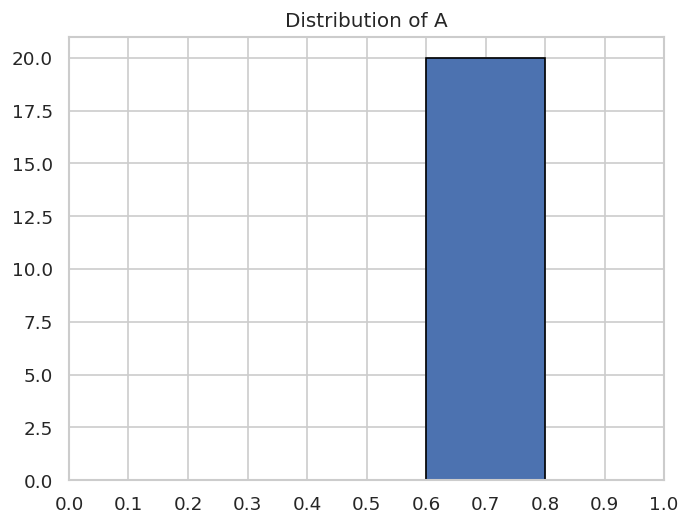

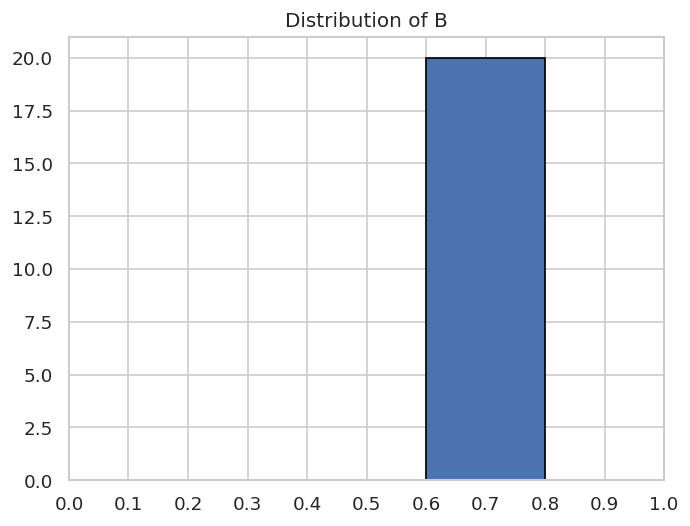

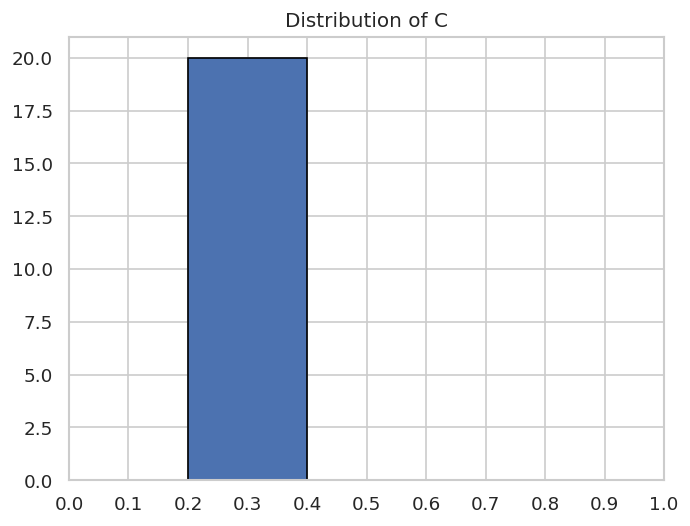

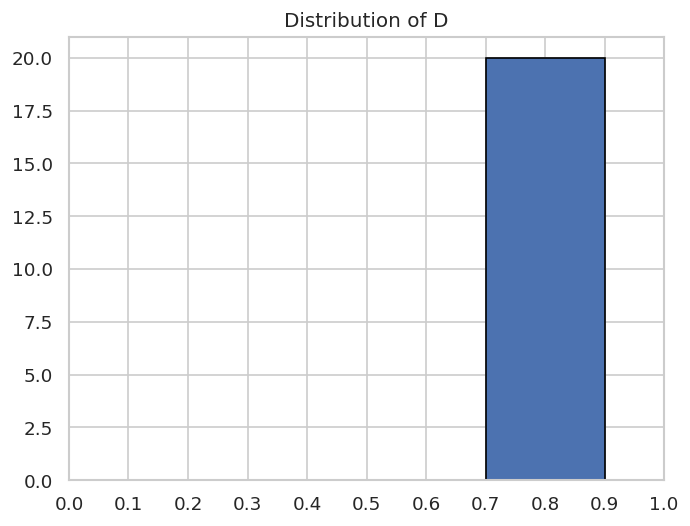

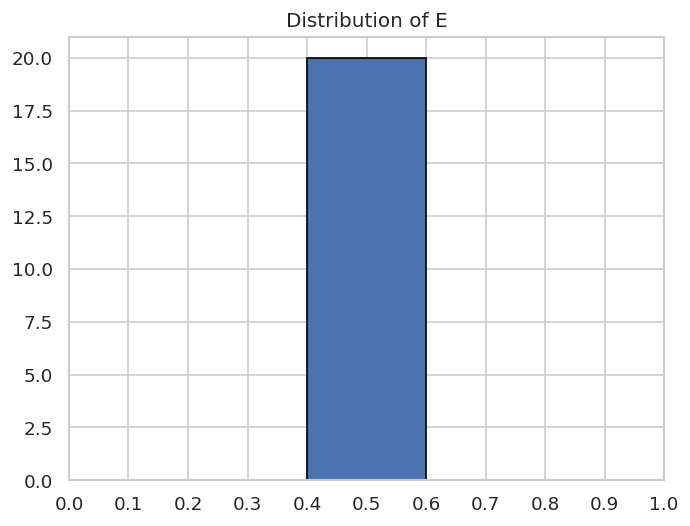

In [ ]:
# Convert the MLP-optimized candidates to a PyTorch tensor

mlp_optimized_df = pd.DataFrame(baseline_x, columns=["A", "B", "C", "D", "E"])

import numpy as np
import matplotlib.pyplot as plt

bins = np.arange(0, 1.1, 0.1)   # 구간: 0.0–0.2–0.4–0.6–0.8–1.0
width = 0.2                     # 각 막대 너비

for attr in ['A', 'B', 'C', 'D', 'E']:
    plt.figure(dpi=120)
    counts, _ = np.histogram(mlp_optimized_df[attr], bins=bins)

    # bar plot처럼 꽉 찬 막대 출력
    plt.bar(bins[:-1], counts, width=width, align='edge', edgecolor='black')

    plt.xticks(bins)
    plt.xlim(0, 1)
    plt.title(f"Distribution of {attr}")
    plt.show()


In [ ]:

nemo_x, nemo_score, nemo_traj = run_ascent_with_traj(
    score_nemo_mlp_lcb_torch,
    num_steps=EVAL_NUM_STEPS,
    lr=LR,
    record_interval=RECORD_INT,
    device=device
)
print(nemo_x)
print(nemo_score)


[[0.70928884 0.5725298  0.22435088 0.7753432  0.40581307]
 [0.7088316  0.57306767 0.2230998  0.77885693 0.40545642]
 [0.70901215 0.5725941  0.22428717 0.7754945  0.4057407 ]
 [0.70576614 0.5757691  0.21768028 0.79222614 0.4042121 ]
 [0.70455617 0.575397   0.21787722 0.79366    0.40399975]
 [0.709274   0.572737   0.22396769 0.77546936 0.4054974 ]
 [0.7083173  0.57300645 0.22267649 0.77881473 0.40524465]
 [0.7089373  0.5728911  0.22417404 0.7760742  0.40567413]
 [0.7095266  0.5725313  0.22417906 0.7751152  0.40557224]
 [0.7087528  0.57250994 0.22410755 0.775494   0.40555486]
 [0.70931274 0.5727808  0.22370633 0.7758157  0.40568995]
 [0.7078244  0.5739929  0.22118625 0.7826275  0.4050774 ]
 [0.7076709  0.57381284 0.2215     0.7831067  0.404936  ]
 [0.70760286 0.57376075 0.22119702 0.78306043 0.4051022 ]
 [0.70585614 0.57508624 0.2185032  0.79034555 0.4044675 ]
 [0.7093038  0.57254326 0.22410986 0.7752482  0.4056972 ]
 [0.7091304  0.572773   0.2240689  0.77582276 0.4058417 ]
 [0.7090907  0

In [ ]:

roma_x, roma_score, roma_traj = run_ascent_with_traj(
    score_roma_mlp_lcb_torch,
    num_steps=EVAL_NUM_STEPS,
    lr=LR,
    record_interval=RECORD_INT,
    device=device
)
print(roma_x)
print(roma_score)


[[0.6623391  0.5963043  0.21456374 0.7939507  0.39740798]
 [0.66231877 0.59619296 0.21459699 0.7939313  0.397417  ]
 [0.66225845 0.5963267  0.21457553 0.79396826 0.3974606 ]
 [0.6623058  0.5963012  0.21461804 0.7939525  0.39737615]
 [0.6623031  0.5963107  0.21460812 0.79398966 0.39741293]
 [0.662297   0.5963265  0.2145898  0.7939836  0.39743423]
 [0.6623155  0.5963274  0.21458216 0.7939622  0.39742655]
 [0.6623105  0.5963375  0.21460573 0.7938998  0.39734098]
 [0.66235495 0.5963124  0.21458831 0.793974   0.3974065 ]
 [0.6623379  0.5963479  0.21460167 0.7939949  0.39750254]
 [0.66240495 0.5963407  0.21457773 0.7939951  0.3975008 ]
 [0.6622852  0.5963104  0.21461733 0.7939323  0.39740223]
 [0.66227806 0.59631056 0.21462789 0.7939292  0.39741775]
 [0.66227335 0.59632313 0.21458888 0.79396087 0.3973904 ]
 [0.6623401  0.596323   0.21459886 0.7939569  0.39751714]
 [0.6622872  0.5963476  0.21459822 0.7939428  0.3974249 ]
 [0.66238177 0.59632593 0.21459511 0.79391026 0.39751405]
 [0.6622875  0

In [ ]:
coms_x, coms_score, coms_traj = run_ascent_with_traj(
    score_coms_mlp_lcb_torch,
    num_steps=EVAL_NUM_STEPS,
    lr=LR,
    record_interval=RECORD_INT,
    device=device
)


In [ ]:

print("\nFinal scores (MLP ascent):")
print("Baseline MLP max/mean:", baseline_score.max(), baseline_score.mean())
print("RoMA MLP   max/mean:", roma_score.max(), roma_score.mean())
print("NeMO MLP   max/mean:", nemo_score.max(), nemo_score.mean())
print("COMs MLP   max/mean:", coms_score.max(), coms_score.mean())


Final scores (MLP ascent):
Baseline MLP max/mean: 92.947136 92.94617
RoMA MLP   max/mean: 90.35867 90.35866
NeMO MLP   max/mean: 91.496826 91.496025
COMs MLP   max/mean: 82.903404 76.57307


In [ ]:
from sklearn.metrics import pairwise_distances

def calculate_ood_distance(candidate_points, training_data):
    distances = pairwise_distances(candidate_points, training_data)
    return distances.min(axis=1)


def plot_trajectories_pca(offline_X, traj_dict, offline_sample=2000, title_suffix=""):
    # Subsample offline for plotting
    if len(offline_X) > offline_sample:
        idx = np.random.choice(len(offline_X), size=offline_sample, replace=False)
        offline_sub = offline_X[idx]
    else:
        offline_sub = offline_X

    # Flatten trajectories
    all_points = [offline_sub]
    segments = {}
    start_idx = len(offline_sub)

    for label, traj in traj_dict.items():
        T, S, D = traj.shape
        flat = traj.reshape(T * S, D)
        end_idx = start_idx + T * S
        segments[label] = (start_idx, end_idx, (T, S))
        all_points.append(flat)
        start_idx = end_idx

    all_points = np.vstack(all_points)

    # PCA to 2D
    pca = PCA(n_components=2, random_state=0)
    emb = pca.fit_transform(all_points)

    i_off_end = len(offline_sub)
    emb_off = emb[:i_off_end]

    plt.figure(figsize=(7, 6))
    plt.scatter(emb_off[:, 0], emb_off[:, 1], s=5, alpha=0.2, color='gray', label="offline log")

    # Define colors for trajectories
    colors = {
        "Vanilla MLP": "black",    # baseline
        "NeMO MLP": "tab:orange",
        "RoMA MLP": "tab:green",
        "COMs MLP": "tab:red",
        "GP baseline" : "black",
        "GP NeMO": "tab:purple",
        "GP RoMA": "tab:pink",
        "GP COMs": "tab:olive",
    }

    for label, (start, end, (T, S)) in segments.items():
        emb_seg = emb[start:end]
        emb_traj = emb_seg.reshape(T, S, 2)
        c = colors.get(label, "black")  # default black if label missing
        for t in range(T):
            xs = emb_traj[t, :, 0]
            ys = emb_traj[t, :, 1]
            plt.plot(xs, ys, '-', alpha=0.3, linewidth=1.0, label=label if t == 0 else None, color=c)
            plt.scatter(xs[-1], ys[-1], s=20, color=c)

    plt.title(f"Optimization trajectories in PCA space {title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


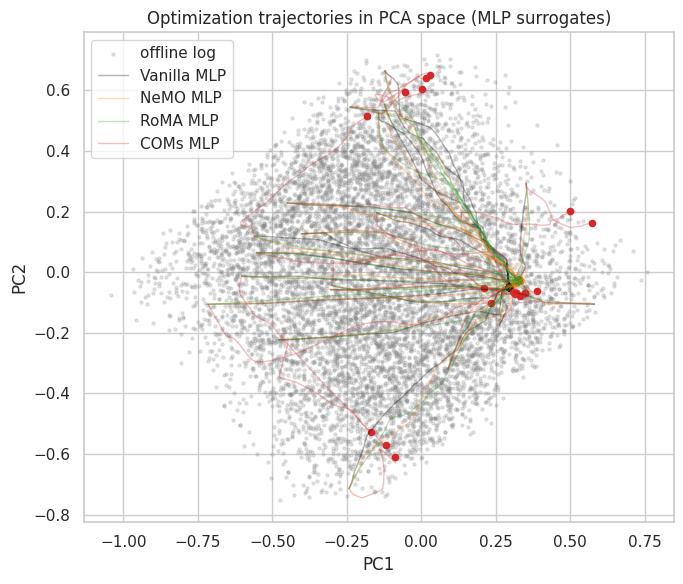

In [ ]:
traj_dict_mlp = {
    "Vanilla MLP": baseline_traj,
    "NeMO MLP": nemo_traj,
    "RoMA MLP": roma_traj,
    "COMs MLP": coms_traj,
}

plot_trajectories_pca(X, traj_dict_mlp, offline_sample=9000, title_suffix="(MLP surrogates)")

In [ ]:
def plot_trajectories_pca_with_ood(
    offline_X,
    X_train,
    traj_dict,
    offline_sample=2000,
    random_state=0,
):
    """
    offline_X    : (N_off, 5) 전체 로그 (A..E)
    X_train      : (N_train, 5) train set (OOD distance 기준)
    traj_dict    : {label: (T, S, 5) trajectory array}
    """

    rng = np.random.default_rng(random_state)

    # ---------- 1) offline subsample ----------
    offline_X = np.asarray(offline_X, dtype=np.float32)
    n_off = min(len(offline_X), offline_sample)
    idx_off = rng.choice(len(offline_X), size=n_off, replace=False)
    off_sub = offline_X[idx_off]

    # ---------- 2) flatten trajectories ----------
    flat_trajectories = []
    traj_shapes = {} # To store (T, S) and start/end indices for each trajectory
    current_idx_in_flat = len(off_sub)

    for label, traj_array in traj_dict.items():
        T, S, D = traj_array.shape
        flat_traj = traj_array.reshape(T * S, D)
        flat_trajectories.append(flat_traj)
        traj_shapes[label] = (T, S, current_idx_in_flat, current_idx_in_flat + T*S)
        current_idx_in_flat += T*S

    # ---------- 3) PCA fit on (offline + all trajectories) ----------
    X_all = np.vstack([off_sub] + flat_trajectories)

    pca = PCA(n_components=2, random_state=random_state)
    print(f"[PCA-OOD] Fitting PCA on {len(X_all)} points...")
    emb_all = pca.fit_transform(X_all)
    print("[PCA-OOD] PCA finished.")

    # ---------- 4) 분할: offline / 각 모델 ----------
    emb_off = emb_all[:len(off_sub)]

    # Reshape 2D embeddings for each trajectory
    emb_trajectories_2d = {}
    for label, (T, S, start_idx, end_idx) in traj_shapes.items():
        emb_trajectories_2d[label] = emb_all[start_idx:end_idx].reshape(T, S, 2)

    # ---------- 5) 원래 5D에서 endpoint 추출 + OOD distance ----------
    ood_distances_per_model = {}
    all_ood_values = []
    for label, traj_array in traj_dict.items():
        endpoints = traj_array[:, -1, :] # (T, 5)
        ood_vals = calculate_ood_distance(endpoints, X_train)
        ood_distances_per_model[label] = ood_vals
        all_ood_values.append(ood_vals)

    # 공통 색상 스케일 만들기 (모든 모델 endpoint 합쳐서 min/max)
    ood_all_combined = np.concatenate(all_ood_values)
    norm = plt.Normalize(vmin=ood_all_combined.min(), vmax=ood_all_combined.max())
    cmap = plt.get_cmap("viridis")

    # ---------- 6) 그림 그리기 ----------
    plt.figure(figsize=(10, 8), dpi=120)
    sns.scatterplot(
        x=emb_off[:, 0],
        y=emb_off[:, 1],
        color="lightgray",
        alpha=0.4,
        s=8,
        label="offline log",
    )

    # Define markers for different model types
    markers = {
        "Vanilla MLP": "o", "NeMO MLP": "^", "RoMA MLP": "s", "COMs MLP": "D",
        "GP baseline": "o", "GP NeMO": "^", "GP RoMA": "s", "GP COMs": "D"
    }
    colors_dict = {
        "Vanilla MLP": "gray", "NeMO MLP": "tab:orange", "RoMA MLP": "tab:green", "COMs MLP": "tab:red",
        "GP baseline": "black", "GP NeMO": "tab:orange", "GP RoMA": "tab:green", "GP COMs": "tab:red",
    }

    first_plot_entry_lines = set()
    for label, emb_traj_2d in emb_trajectories_2d.items():
        T = emb_traj_2d.shape[0]
        c = colors_dict.get(label, "blue") # Default color if not in dict
        marker = markers.get(label, "o")

        # Plot trajectory lines
        for i in range(T):
            plt.plot(emb_traj_2d[i, :, 0], emb_traj_2d[i, :, 1],
                     color=c, alpha=0.5, linewidth=1,
                     label=label if label not in first_plot_entry_lines else None)
            if label not in first_plot_entry_lines:
                first_plot_entry_lines.add(label)

        # Plot endpoints with OOD-colored markers
        ood_vals = ood_distances_per_model[label]
        sc = plt.scatter(
            emb_traj_2d[:, -1, 0],
            emb_traj_2d[:, -1, 1],
            c=ood_vals,
            norm=norm,
            cmap=cmap,
            s=80,
            marker=marker,
            edgecolor="k",
            label=f"{label} (endpoints)",
        )

    # Add a single colorbar using the last scatter object (sc)
    cbar = plt.colorbar(sc)
    cbar.set_label("OOD distance (min dist to train)")

    plt.title("Optimization trajectories in PCA space (MLP & GP surrogates)\n(endpoint color = OOD distance)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="upper left") # Place legend outside to not overlap
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


[PCA-OOD] Fitting PCA on 17080 points...
[PCA-OOD] PCA finished.


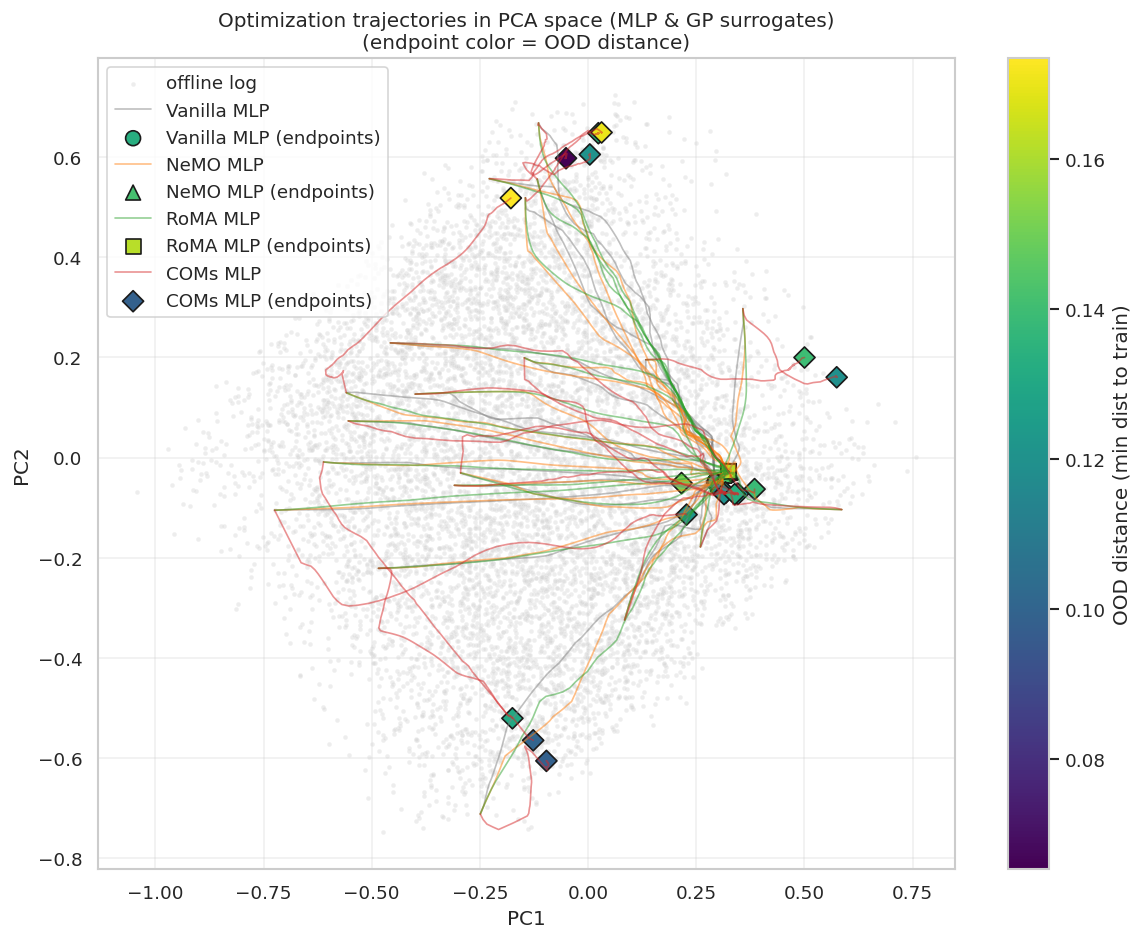

In [ ]:
plot_trajectories_pca_with_ood(X, traj_dict = traj_dict_mlp, X_train = X_train, offline_sample=9000)

## 4. GP backbone + NeMO / COMs / RoMA (GP‑based) and DIRECT

We now build a **Gaussian Process regression baseline** with an ARD RBF kernel and construct NeMO / RoMA / COMs judges on top of it.

For the GP, we use scikit‑learn’s `GaussianProcessRegressor`:

- Kernel: \(k(x,x') = c^2 \exp(-\tfrac{1}{2}\sum_j ((x_j - x'_j)/\ell_j)^2)\) with one length‑scale per activity.
- We fit on a subset of the training data (optional) to keep things tractable.

We then:

1. Run `run_ascent_with_traj` on the **vanilla GP mean** to show local search behavior (can get stuck in local maxima depending on initialization).
2. Optimize GP‑NeMO / GP‑RoMA / GP‑COMs objectives with **DIRECT** (global search) to get strong candidates.

We also reuse the GP judges later for evaluating all candidate timetables when constructing frontiers.


In [ ]:
# Cell 7 – GP baseline + GP‑NeMO / GP‑RoMA / GP‑COMs + DIRECT

max_gp_train_points = 2000  # subsample if needed

if len(X_train) > max_gp_train_points:
    idx_sub = np.random.choice(len(X_train), size=max_gp_train_points, replace=False)
    X_train_gp = X_train[idx_sub]
    y_train_gp = y_train[idx_sub]
else:
    X_train_gp = X_train
    y_train_gp = y_train

# Normalize y for GP (using same mean/std as MLP for consistency)
y_train_scaled = (y_train_gp - y_mean) / y_std

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(5), length_scale_bounds=(1e-3, 1e1))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-2,
    n_restarts_optimizer=2,
    normalize_y=False,
    random_state=0,
)

print(f"Fitting GP on {len(X_train_gp)} points...")
gp.fit(X_train_gp, y_train_scaled.ravel())
print("Optimized kernel:")
print(gp.kernel_)


Fitting GP on 2000 points...
Optimized kernel:
0.727**2 * RBF(length_scale=[0.538, 0.539, 0.523, 0.517, 0.542])


In [ ]:
# ============================
# GP 예측 함수 (변경 없음)
# ============================
def gp_predict(X_new):
    """Predictive mean (original scale) and std for a batch of points.

    X_new: (N,5) array (expected to be numpy array)
    Returns mu, std of shape (N,)
    """
    X_new = np.asarray(X_new, dtype=np.float32)
    mu_scaled, std = gp.predict(X_new, return_std=True)
    mu = mu_scaled * y_std + y_mean
    return mu.reshape(-1), std.reshape(-1)


# Evaluate GP on train/valid/test
for split_name, X_split, y_split in [
    ("train_subset", X_train_gp, y_train_gp),
    ("valid",       X_valid,    y_valid),
    ("test",        X_test,     y_test),
]:
    mu, std = gp_predict(X_split)
    rmse = np.sqrt(mean_squared_error(y_split, mu))
    r2   = r2_score(y_split, mu)
    print(f"GP {split_name:12s} RMSE={rmse:6.3f}, R^2={r2:6.3f}")

GP train_subset RMSE= 0.336, R^2= 0.994
GP valid        RMSE= 0.390, R^2= 0.992
GP test         RMSE= 0.393, R^2= 0.992


In [ ]:

# GP‑based judges (these are expected to take numpy inputs)

def nemo_gp_mu_sigma(x_np):
    mu, sigma = gp_predict(x_np[None, :])
    return float(mu[0]), float(sigma[0])


def score_nemo_gp_lcb(x_torch, kappa=KAPPA):
    # Convert torch tensor input to numpy array on CPU for gp_predict
    x_np = x_torch.detach().cpu().numpy()
    mu, sigma = nemo_gp_mu_sigma(x_np)
    return torch.tensor(mu - kappa * sigma, device=device, dtype=torch.float32)


def roma_gp_mu_sigma(x_np, noise_scale=0.05):
    X_noisy = x_np[None, :] + noise_scale * _noise_dirs_np # Use numpy noise_dirs_np
    X_noisy = np.clip(X_noisy, 0.0, 1.0)
    mu_noisy, _ = gp_predict(X_noisy)
    mu_roma = float(mu_noisy.mean())
    sigma_roma = float(mu_noisy.std() + 1e-6)
    return mu_roma, sigma_roma


def score_roma_gp_lcb(x_torch, kappa=KAPPA):
    # Convert torch tensor input to numpy array on CPU for roma_gp_mu_sigma
    x_np = x_torch.detach().cpu().numpy()
    mu, sigma = roma_gp_mu_sigma(x_np)
    return torch.tensor(mu - kappa * sigma, device=device, dtype=torch.float32)


def coms_gp_mu_sigma(x_np, delta=0.10):
    mu_clean, _ = gp_predict(x_np[None, :])
    mu_clean = float(mu_clean[0])

    X_adv = x_np[None, :] + delta * _noise_dirs_np # Use numpy noise_dirs_np
    X_adv = np.clip(X_adv, 0.0, 1.0)
    mu_adv, _ = gp_predict(X_adv)
    mu_coms = float(mu_adv.min())
    sigma_coms = max(1e-6, mu_clean - mu_coms)
    return mu_coms, sigma_coms


def score_coms_gp_lcb(x_torch, kappa=KAPPA):
    # Convert torch tensor input to numpy array on CPU for coms_gp_mu_sigma
    x_np = x_torch.detach().cpu().numpy()
    mu, sigma = coms_gp_mu_sigma(x_np)
    return torch.tensor(mu - kappa * sigma, device=device, dtype=torch.float32)


# Gradient ascent on vanilla GP mean (to see local minima / trapping)

def score_gp_mean(x_torch):
    # Convert torch tensor input to numpy array on CPU for gp_predict
    x_np = x_torch.detach().cpu().numpy()
    mu, _ = gp_predict(x_np[None, :])
    return torch.tensor(mu[0], device=device, dtype=torch.float32)


In [ ]:

# ============================
# NumPy 기반 GP score 함수 (_gp 접미사)
# ============================
def score_gp_mean_gp(x_np):
    """Vanilla GP mean (maximize)"""
    mu, _ = gp_predict(x_np[None, :])
    return float(mu[0])


def score_nemo_gp_lcb_gp(x_np, kappa=KAPPA):
    mu, sigma = nemo_gp_mu_sigma(x_np)
    return mu - kappa * sigma


def score_roma_gp_lcb_gp(x_np, kappa=KAPPA):
    mu, sigma = roma_gp_mu_sigma(x_np)
    return mu - kappa * sigma


def score_coms_gp_lcb_gp(x_np, kappa=KAPPA):
    mu, sigma = coms_gp_mu_sigma(x_np)
    return mu - kappa * sigma


# ============================
# GP용 gradient ascent (NumPy 버전)
# ============================
def run_ascent_with_traj_gp(score_fn_np,
                            num_trials=20,
                            num_steps=200,
                            lr=1e-2,
                            record_interval=10):
    """Gradient ascent using finite differences on NumPy-based score function."""
    xs_final = []
    scores_final = []
    trajs = []
    for t in range(num_trials):
        print(f"nth trail : ", t)
        x = INIT_POINTS_NP[t]
        traj = []

        for step in range(num_steps):
            if step % record_interval == 0 or step == num_steps - 1:
                traj.append(x.copy())

            # Finite difference gradient approximation
            grad = np.zeros_like(x)
            eps = 1e-7
            for i in range(len(x)):
                x_eps = x.copy()
                x_eps[i] += eps
                eps_vec = np.zeros_like(x)  # x와 같은 길이
                eps_vec[i] = eps             # i번째 좌표만 eps 만큼 이동
                # f1 = score_fn_np(x_eps)
                # f0 = score_fn_np(x)
                #grad[i] = (f1 - f0) / eps
                grad[i] = (score_fn_np(x + eps_vec) - score_fn_np(x - eps_vec)) / (2*eps)


            x += lr * grad
            x = np.clip(x, 0.0, 1.0)

        trajs.append(np.stack(traj, axis=0))
        xs_final.append(x.copy())
        scores_final.append(score_fn_np(x))  # final score

    xs_final = np.stack(xs_final, axis=0)
    scores_final = np.array(scores_final, dtype=np.float32)
    trajs = np.stack(trajs, axis=0)
    return xs_final, scores_final, trajs


# ============================
# 실행 예시
# ============================
EVAL_NUM_TRIALS = 20
EVAL_NUM_STEPS = 1000
RECORD_INT = 10
print("\n=== GP baseline (vanilla mean) ascent ===")
gp_x, gp_score, gp_traj = run_ascent_with_traj_gp(
    score_gp_mean_gp,
    num_trials=EVAL_NUM_TRIALS,
    num_steps=EVAL_NUM_STEPS,
    lr=1e-4,
    record_interval=RECORD_INT
)
print("\n=== GP NeMO ascent ===")
gp_nemo_x, gp_nemo_score, gp_nemo_traj = run_ascent_with_traj_gp(
    score_nemo_gp_lcb_gp,
    num_trials=EVAL_NUM_TRIALS,
    num_steps=EVAL_NUM_STEPS,
    lr=1e-4,
    record_interval=RECORD_INT
)
print("\n=== GP RoMA ascent ===")
gp_roma_x, gp_roma_score, gp_roma_traj = run_ascent_with_traj_gp(
    score_roma_gp_lcb_gp,
    num_trials=EVAL_NUM_TRIALS,
    num_steps=EVAL_NUM_STEPS,
    lr=1e-4,
    record_interval=RECORD_INT
)
print("\n=== GP COMS ascent ===")
gp_coms_x, gp_coms_score, gp_coms_traj = run_ascent_with_traj_gp(
    score_coms_gp_lcb_gp,
    num_trials=EVAL_NUM_TRIALS,
    num_steps=EVAL_NUM_STEPS,
    lr=1e-4,
    record_interval=RECORD_INT
)
print("GP baseline final score max/mean:", gp_score.max(), gp_score.mean())





=== GP baseline (vanilla mean) ascent ===
nth trail :  0
nth trail :  1
nth trail :  2
nth trail :  3
nth trail :  4
nth trail :  5
nth trail :  6
nth trail :  7
nth trail :  8
nth trail :  9
nth trail :  10
nth trail :  11
nth trail :  12
nth trail :  13
nth trail :  14
nth trail :  15
nth trail :  16
nth trail :  17
nth trail :  18
nth trail :  19

=== GP NeMO ascent ===
nth trail :  0
nth trail :  1
nth trail :  2
nth trail :  3
nth trail :  4
nth trail :  5
nth trail :  6
nth trail :  7
nth trail :  8
nth trail :  9
nth trail :  10
nth trail :  11
nth trail :  12
nth trail :  13
nth trail :  14
nth trail :  15
nth trail :  16
nth trail :  17
nth trail :  18
nth trail :  19

=== GP RoMA ascent ===
nth trail :  0
nth trail :  1
nth trail :  2
nth trail :  3
nth trail :  4
nth trail :  5
nth trail :  6
nth trail :  7
nth trail :  8
nth trail :  9
nth trail :  10
nth trail :  11
nth trail :  12
nth trail :  13
nth trail :  14
nth trail :  15
nth trail :  16
nth trail :  17
nth trail :

[PCA-OOD] Fitting PCA on 17080 points...
[PCA-OOD] PCA finished.


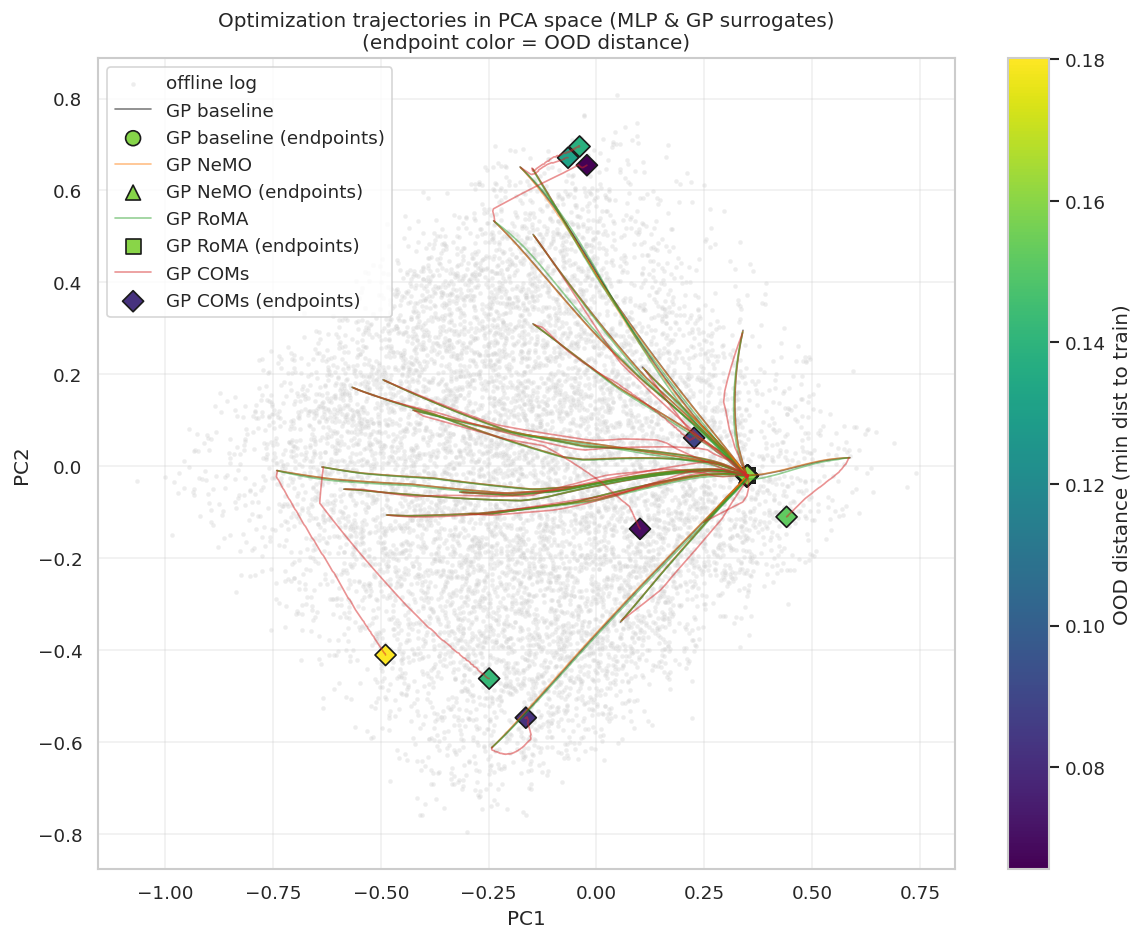

In [ ]:
    #"Vanilla MLP": baseline_traj,
    # "NeMO MLP": nemo_traj,
    # "RoMA MLP": roma_traj,
    # "COMs MLP": coms_traj,
traj_dict = {
    "GP baseline": gp_traj,
    "GP NeMO": gp_nemo_traj,
    "GP RoMA": gp_roma_traj,
    "GP COMs": gp_coms_traj,
}

plot_trajectories_pca_with_ood(
    offline_X=X,
    X_train=X_train,
    traj_dict=traj_dict,
    offline_sample=9000
)


In [ ]:

# DIRECT optimization for GP‑NeMO / GP‑RoMA / GP‑COMs

bounds = Bounds(lb=np.zeros(5), ub=np.ones(5))

def direct_maximize(score_fn, bounds, maxfun=2000, len_tol=1e-3):
    """Use scipy.optimize.direct to maximize score_fn over given bounds."""
    def obj_to_minimize(x, *args):
        return -score_fn(np.array(x, dtype=np.float64))
    res = direct(obj_to_minimize, bounds, maxfun=maxfun, len_tol=len_tol)
    x_opt = np.array(res.x, dtype=np.float32)
    f_opt = -res.fun
    return x_opt, f_opt, res

print(KAPPA)

print("\n=== DIRECT on GP‑NeMO LCB ===")
x_direct_nemo, f_direct_nemo, res_nemo = direct_maximize(score_nemo_gp_lcb_gp, bounds)
print("GP‑NeMO DIRECT best score:", f_direct_nemo)

print("\n=== DIRECT on GP‑RoMA LCB ===")
x_direct_roma, f_direct_roma, res_roma = direct_maximize(score_roma_gp_lcb_gp, bounds)
print("GP‑RoMA DIRECT best score:", f_direct_roma)

print("\n=== DIRECT on GP‑COMs LCB ===")
x_direct_coms, f_direct_coms, res_coms = direct_maximize(score_coms_gp_lcb_gp, bounds)
print("GP‑COMs DIRECT best score:", f_direct_coms)


1.0

=== DIRECT on GP‑NeMO LCB ===
GP‑NeMO DIRECT best score: 89.20680494443005

=== DIRECT on GP‑RoMA LCB ===
GP‑RoMA DIRECT best score: 89.06467982453248

=== DIRECT on GP‑COMs LCB ===
GP‑COMs DIRECT best score: 87.87477170114992


In [ ]:
def plot_mlp_gp_direct_with_offline(
    offline_X,
    traj_mlp,
    traj_gp,
    x_direct=None,
    model_label="RoMA",
    offline_sample=2000,
    random_state=0,
):
    """
    offline_X : (N_off, 5) offline log (A..E)
    traj_mlp  : (T, S, 5) MLP-based trajectories for a single judge
    traj_gp   : (T, S, 5) GP-based trajectories for the same judge
    x_direct  : (5,) or (1,5) optional DIRECT optimum (GP-based) for this judge
    model_label : string used only for titles/legend (e.g., "NeMO", "RoMA", "COMs")
    """

    # --- 0. to numpy / basic shapes ---
    offline_X = np.asarray(offline_X, dtype=np.float32)
    traj_mlp  = np.asarray(traj_mlp,  dtype=np.float32)
    traj_gp   = np.asarray(traj_gp,   dtype=np.float32)

    T_mlp, S_mlp, D = traj_mlp.shape
    T_gp,  S_gp,  D2 = traj_gp.shape
    assert D == 5 and D2 == 5, "Design dimension must be 5."

    rng = np.random.default_rng(random_state)

    # --- 1. offline subsample ---
    if len(offline_X) > offline_sample:
        idx_off = rng.choice(len(offline_X), size=offline_sample, replace=False)
        off_sub = offline_X[idx_off]
    else:
        off_sub = offline_X

    # --- 2. flatten trajectories & fit PCA on everything ---
    flat_mlp = traj_mlp.reshape(-1, 5)   # (T_mlp * S_mlp, 5)
    flat_gp  = traj_gp.reshape(-1, 5)    # (T_gp  * S_gp,  5)

    X_all = np.vstack([off_sub, flat_mlp, flat_gp])
    pca = PCA(n_components=2, random_state=random_state)
    emb_all = pca.fit_transform(X_all)

    # --- 3. split back into offline / MLP / GP ---
    n_off   = len(off_sub)
    n_mlp   = flat_mlp.shape[0]
    n_gp    = flat_gp.shape[0]

    emb_off       = emb_all[:n_off]
    start         = n_off
    emb_mlp_flat  = emb_all[start:start + n_mlp]
    start        += n_mlp
    emb_gp_flat   = emb_all[start:start + n_gp]

    emb_mlp_traj = emb_mlp_flat.reshape(T_mlp, S_mlp, 2)
    emb_gp_traj  = emb_gp_flat.reshape(T_gp,  S_gp,  2)

    # --- 4. endpoints (마지막 step) ---
    emb_mlp_end = emb_mlp_traj[:, -1, :]   # (T_mlp, 2)
    emb_gp_end  = emb_gp_traj[:,  -1, :]   # (T_gp,  2)

    # --- 5. 색상 선택 (judge 이름에 따라) ---
    name_lower = model_label.lower()
    if "nemo" in name_lower:
        c_mlp = "tab:orange"
        c_gp  = "tab:purple"
    elif "roma" in name_lower:
        c_mlp = "tab:green"
        c_gp  = "tab:pink"
    elif "coms" in name_lower or "com" in name_lower:
        c_mlp = "tab:red"
        c_gp  = "tab:olive"
    else:
        # vanilla / baseline / 기타
        c_mlp = "gray"
        c_gp  = "black"

    # --- 6. plotting ---
    plt.figure(figsize=(10, 8), dpi=120)

    # 6-1) offline background
    plt.scatter(
        emb_off[:, 0], emb_off[:, 1],
        s=8, alpha=0.25, color="lightgray",
        label="offline log"
    )

    # 6-2) MLP trajectories
    for i in range(T_mlp):
        plt.plot(
            emb_mlp_traj[i, :, 0],
            emb_mlp_traj[i, :, 1],
            "-", linewidth=1.0, alpha=0.5, color=c_mlp,
            label=f"MLP {model_label} traj" if i == 0 else None,
        )

    # 6-3) GP trajectories
    for i in range(T_gp):
        plt.plot(
            emb_gp_traj[i, :, 0],
            emb_gp_traj[i, :, 1],
            "-", linewidth=1.0, alpha=0.6, color=c_gp,
            label=f"GP {model_label} traj" if i == 0 else None,
        )

    # 6-4) endpoints (조금 더 크게)
    plt.scatter(
        emb_mlp_end[:, 0], emb_mlp_end[:, 1],
        s=70, marker="s", color=c_mlp, edgecolor="k",
        label=f"MLP {model_label} endpoints",
    )
    plt.scatter(
        emb_gp_end[:, 0], emb_gp_end[:, 1],
        s=70, marker="D", color=c_gp, edgecolor="k",
        label=f"GP {model_label} endpoints",
    )

    # 6-5) DIRECT optimum (optional, 아주 크게 별표로)
    if x_direct is not None:
        x_direct_np = np.asarray(x_direct, dtype=np.float32).reshape(1, -1)
        emb_direct = pca.transform(x_direct_np)

        plt.scatter(
            emb_direct[0, 0], emb_direct[0, 1],
            s=220, marker="o", color="gold", edgecolor="k", alpha = 0.5, linewidth=1.5,
            label=f"GP {model_label} DIRECT",
            zorder=5,
        )
        # 작은 annotation
        plt.annotate(
            "DIRECT",
            xy=(emb_direct[0, 0], emb_direct[0, 1]),
            xytext=(8, 8),
            textcoords="offset points",
            fontsize=9,
            fontweight="bold",
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{model_label}: MLP vs GP trajectories on offline PCA\n(star = DIRECT optimum)")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


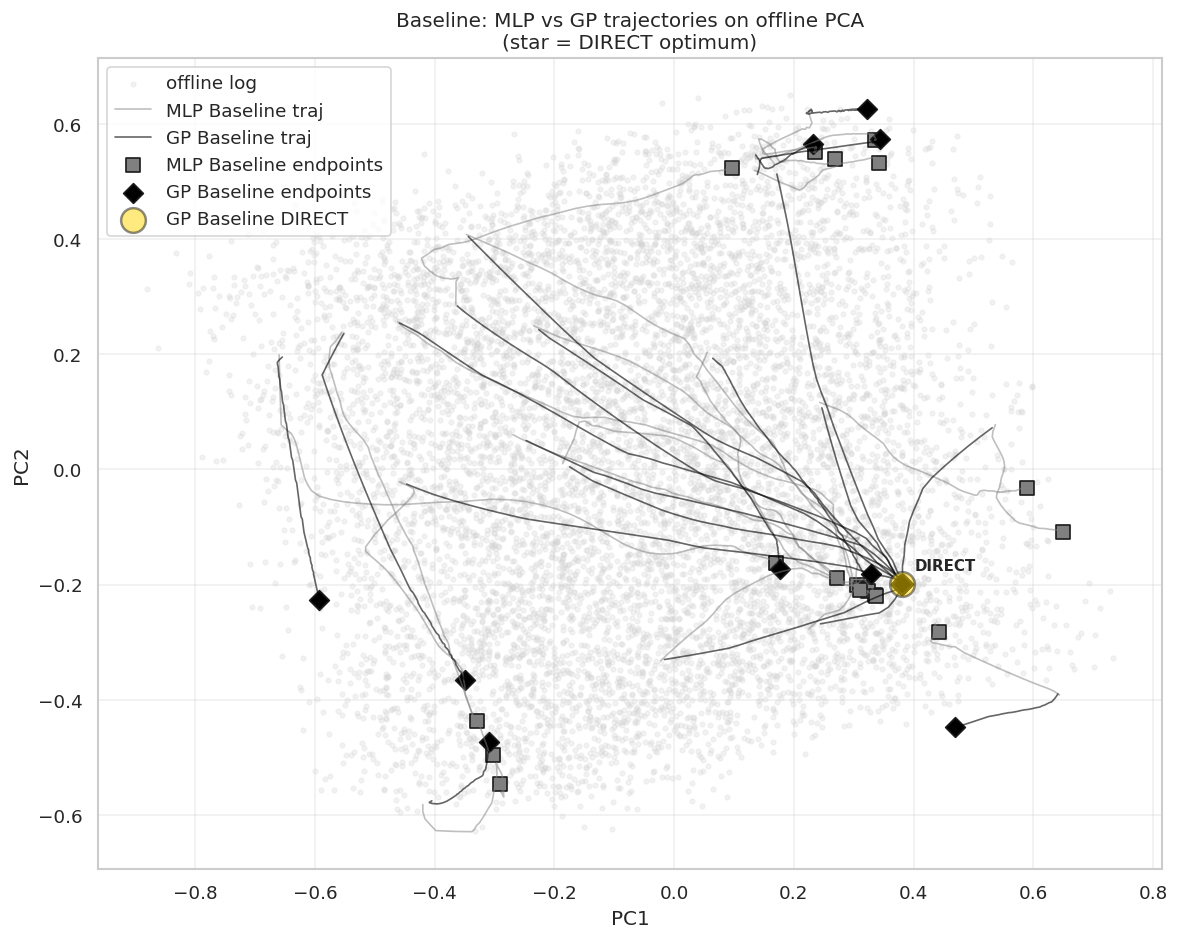

In [ ]:
plot_mlp_gp_direct_with_offline(
    offline_X=X,
    traj_mlp=coms_traj,
    traj_gp=gp_coms_traj,
    x_direct= x_direct_coms,
    model_label="Baseline",
    offline_sample=9000,
    random_state=0,
)


## 5. Flowline, judges, frontier and decision analysis

We now put everything together:

1. Stack all candidate timetables from:
   - MLP ascent: baseline, NeMO, RoMA, COMs.
   - GP baseline ascent.
   - DIRECT for GP‑NeMO / GP‑RoMA / GP‑COMs.
2. For each candidate `x` we compute, under the **GP‑based judges** (to have a common reference):
   - `mu_nemo, sigma_nemo`,
   - `mu_roma, sigma_roma`,
   - `mu_coms, sigma_coms`.
3. Compute **LCB** and **EI** for each judge.
4. Compute **OOD distance** to the training set.
5. Filter to an in‑distribution, risk‑averse subset.
6. Plot risk–reward scatterplots and efficient frontiers.
7. Pick **risk‑neutral** vs **risk‑averse** frontier points and draw **pie charts** of their timetables.
8. Store **top‑5 candidates per model** (by NeMO‑LCB) together with all metadata in an Excel file.


In [ ]:
# Cell 8-1 – Collect candidates, GP judges, OOD, LCB/EI, filtering

# 1) Stack all candidates and record their origin
all_candidates_x = []
model_origin = []
decision_type = []

def add_candidates(xs, origin_label, decision_label):
    xs = np.asarray(xs, dtype=np.float32)
    if xs.ndim == 1:
        xs = xs[None, :]
    all_candidates_x.append(xs)
    model_origin.extend([origin_label] * len(xs))
    decision_type.extend([decision_label] * len(xs))

# From MLP ascent (optional: currently disabled)
# add_candidates(baseline_x, "MLP baseline", "gradient_ascent")
# add_candidates(nemo_x,     "MLP NeMO",    "gradient_ascent")
# add_candidates(roma_x,     "MLP RoMA",    "gradient_ascent")
# add_candidates(coms_x,     "MLP COMs",    "gradient_ascent")

# From GP baseline ascent
add_candidates(gp_x, "GP baseline", "gradient_ascent")

# From DIRECT runs (single best point for each judge)
add_candidates(x_direct_nemo, "GP NeMO",  "DIRECT")
add_candidates(x_direct_roma, "GP RoMA",  "DIRECT")
add_candidates(x_direct_coms, "GP COMs",  "DIRECT")

all_candidates_x = np.vstack(all_candidates_x)
model_origin = np.array(model_origin)
decision_type = np.array(decision_type)

print("Total candidate timetables:", all_candidates_x.shape[0])

# 2) GP-based judges: mu/sigma for each candidate
mu_nemo_list, sigma_nemo_list = [], []
mu_roma_list, sigma_roma_list = [], []
mu_coms_list, sigma_coms_list = [], []

for x in all_candidates_x:
    mu_n, sig_n = nemo_gp_mu_sigma(x)
    mu_r, sig_r = roma_gp_mu_sigma(x)
    mu_c, sig_c = coms_gp_mu_sigma(x)
    mu_nemo_list.append(mu_n)
    sigma_nemo_list.append(sig_n)
    mu_roma_list.append(mu_r)
    sigma_roma_list.append(sig_r)
    mu_coms_list.append(mu_c)
    sigma_coms_list.append(sig_c)

mu_nemo    = np.array(mu_nemo_list)
sigma_nemo = np.array(sigma_nemo_list)
mu_roma    = np.array(mu_roma_list)
sigma_roma = np.array(sigma_roma_list)
mu_coms    = np.array(mu_coms_list)
sigma_coms = np.array(sigma_coms_list)

# 3) OOD distance
ood_distances = calculate_ood_distance(all_candidates_x, X_train)

# 4) LCB and EI per judge
kappa = KAPPA
best_offline_score = df[target].max()
print("Best offline (true) score:", best_offline_score)

def expected_improvement(mu, sigma, best_y, eps=1e-9):
    mu = np.asarray(mu)
    sigma = np.asarray(sigma)
    sigma = np.maximum(sigma, eps)
    diff = mu - best_y
    Z = diff / sigma
    ei = diff * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < eps] = 0.0
    return ei

nemo_lcb = mu_nemo - kappa * sigma_nemo
roma_lcb = mu_roma - kappa * sigma_roma
coms_lcb = mu_coms - kappa * sigma_coms

nemo_ei = expected_improvement(mu_nemo, sigma_nemo, best_offline_score)
roma_ei = expected_improvement(mu_roma, sigma_roma, best_offline_score)
coms_ei = expected_improvement(mu_coms, sigma_coms, best_offline_score)

# 5) Construct DataFrame with all metadata
decision_full_df = pd.DataFrame({
    "model_origin":  model_origin,
    "decision_type": decision_type,
    "ood_distance":  ood_distances,
    "mu_nemo":   mu_nemo,
    "sigma_nemo": sigma_nemo,
    "mu_roma":   mu_roma,
    "sigma_roma": sigma_roma,
    "mu_coms":   mu_coms,
    "sigma_coms": sigma_coms,
    "NeMO_lcb":  nemo_lcb,
    "RoMA_lcb":  roma_lcb,
    "COMs_lcb":  coms_lcb,
    "NeMO_ei":   nemo_ei,
    "RoMA_ei":   roma_ei,
    "COMs_ei":   coms_ei,
})

for i, feat in enumerate(features):
    decision_full_df[feat] = all_candidates_x[:, i]

print("Decision-full DF head:")
display(decision_full_df.head())

# 6) Risk-averse / in-distribution filtering
ood_threshold = 0.16
mask_id = decision_full_df["ood_distance"] <= ood_threshold
decision_id_df = decision_full_df[mask_id].copy()

# Optional: also require LCB >= best_offline - 5 for at least one judge
lcb_max = decision_id_df[["NeMO_lcb", "RoMA_lcb", "COMs_lcb"]].max(axis=1)
mask_good = lcb_max >= (best_offline_score - 3.0)
decision_id_df = decision_id_df[mask_good].copy()

print("\nIn-distribution, risk-aware subset size:", len(decision_id_df))
display(decision_id_df.head())


Total candidate timetables: 23
Best offline (true) score: 89.83092
Decision-full DF head:


,model_origin,decision_type,ood_distance,mu_nemo,sigma_nemo,mu_roma,sigma_roma,mu_coms,sigma_coms,NeMO_lcb,RoMA_lcb,COMs_lcb,NeMO_ei,RoMA_ei,COMs_ei,A,B,C,D,E
0,GP baseline,gradient_ascent,0.159262,89.232870,0.025238,89.068139,0.002401,88.558542,0.674328,89.207631,89.065739,87.884214,2.096777e-127,0.0,0.007712,0.711924,0.603791,0.188198,0.815126,0.403762
1,GP baseline,gradient_ascent,0.159249,89.232870,0.025238,89.068123,0.002417,88.558395,0.674475,89.207632,89.065706,87.883920,2.087641e-127,0.0,0.007718,0.711924,0.603795,0.188206,0.815131,0.403747
2,GP baseline,gradient_ascent,0.159469,89.232861,0.025224,89.068135,0.002278,88.560418,0.672443,89.207638,89.065858,87.887975,1.494935e-127,0.0,0.007641,0.711918,0.603687,0.188452,0.815067,0.403966
3,GP baseline,gradient_ascent,0.159238,89.232870,0.025238,89.068119,0.002425,88.558371,0.674498,89.207632,89.065694,87.883873,2.086126e-127,0.0,0.007719,0.711920,0.603795,0.188207,0.815129,0.403734
4,GP baseline,gradient_ascent,0.159252,89.232870,0.025237,89.068117,0.002407,88.558436,0.674433,89.207632,89.065710,87.884003,2.052916e-127,0.0,0.007716,0.711916,0.603788,0.188220,0.815132,0.403752



In-distribution, risk-aware subset size: 22


,model_origin,decision_type,ood_distance,mu_nemo,sigma_nemo,mu_roma,sigma_roma,mu_coms,sigma_coms,NeMO_lcb,RoMA_lcb,COMs_lcb,NeMO_ei,RoMA_ei,COMs_ei,A,B,C,D,E
0,GP baseline,gradient_ascent,0.159262,89.232870,0.025238,89.068139,0.002401,88.558542,0.674328,89.207631,89.065739,87.884214,2.096777e-127,0.0,0.007712,0.711924,0.603791,0.188198,0.815126,0.403762
1,GP baseline,gradient_ascent,0.159249,89.232870,0.025238,89.068123,0.002417,88.558395,0.674475,89.207632,89.065706,87.883920,2.087641e-127,0.0,0.007718,0.711924,0.603795,0.188206,0.815131,0.403747
2,GP baseline,gradient_ascent,0.159469,89.232861,0.025224,89.068135,0.002278,88.560418,0.672443,89.207638,89.065858,87.887975,1.494935e-127,0.0,0.007641,0.711918,0.603687,0.188452,0.815067,0.403966
3,GP baseline,gradient_ascent,0.159238,89.232870,0.025238,89.068119,0.002425,88.558371,0.674498,89.207632,89.065694,87.883873,2.086126e-127,0.0,0.007719,0.711920,0.603795,0.188207,0.815129,0.403734
4,GP baseline,gradient_ascent,0.159252,89.232870,0.025237,89.068117,0.002407,88.558436,0.674433,89.207632,89.065710,87.884003,2.052916e-127,0.0,0.007716,0.711916,0.603788,0.188220,0.815132,0.403752



=== NeMO judge: risk–reward plane and efficient frontier ===


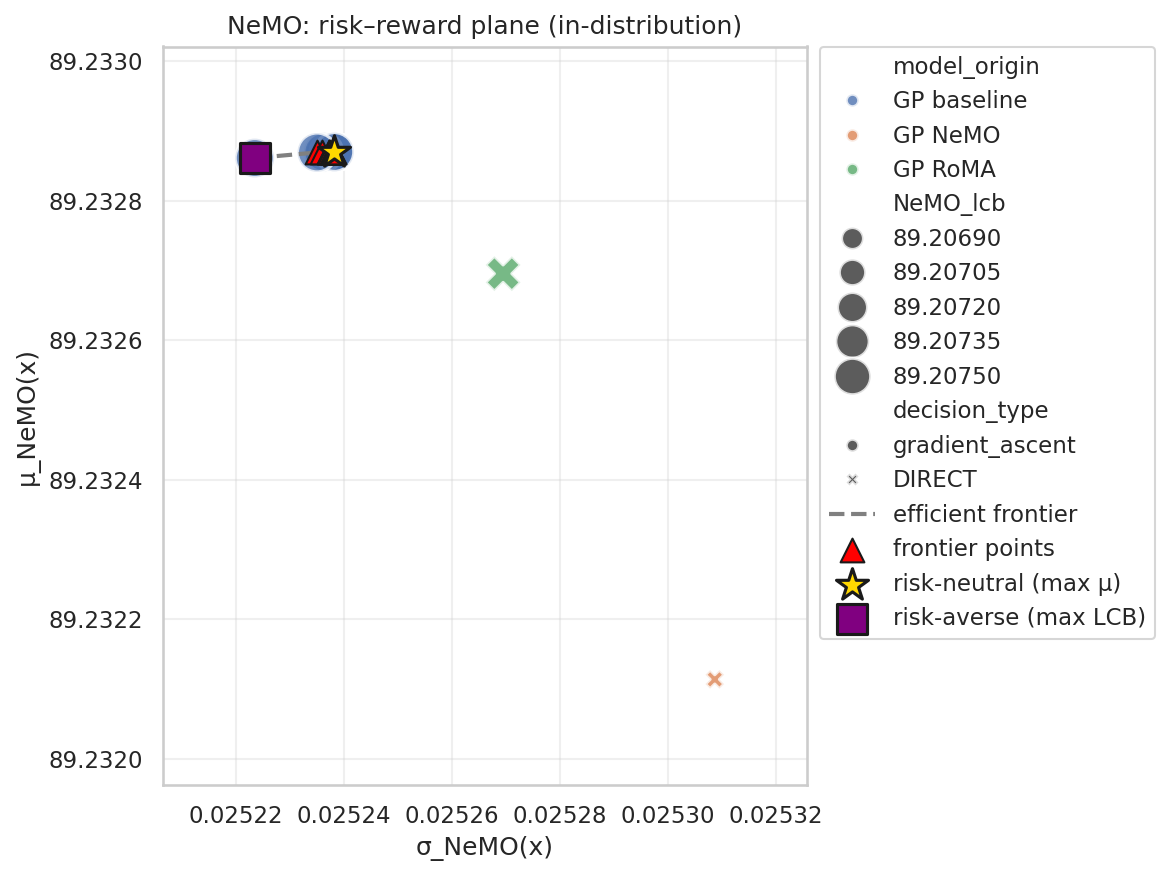

/tmp/ipython-input-376492130.py:317: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0.05, 0.05, 0.95, 0.93))


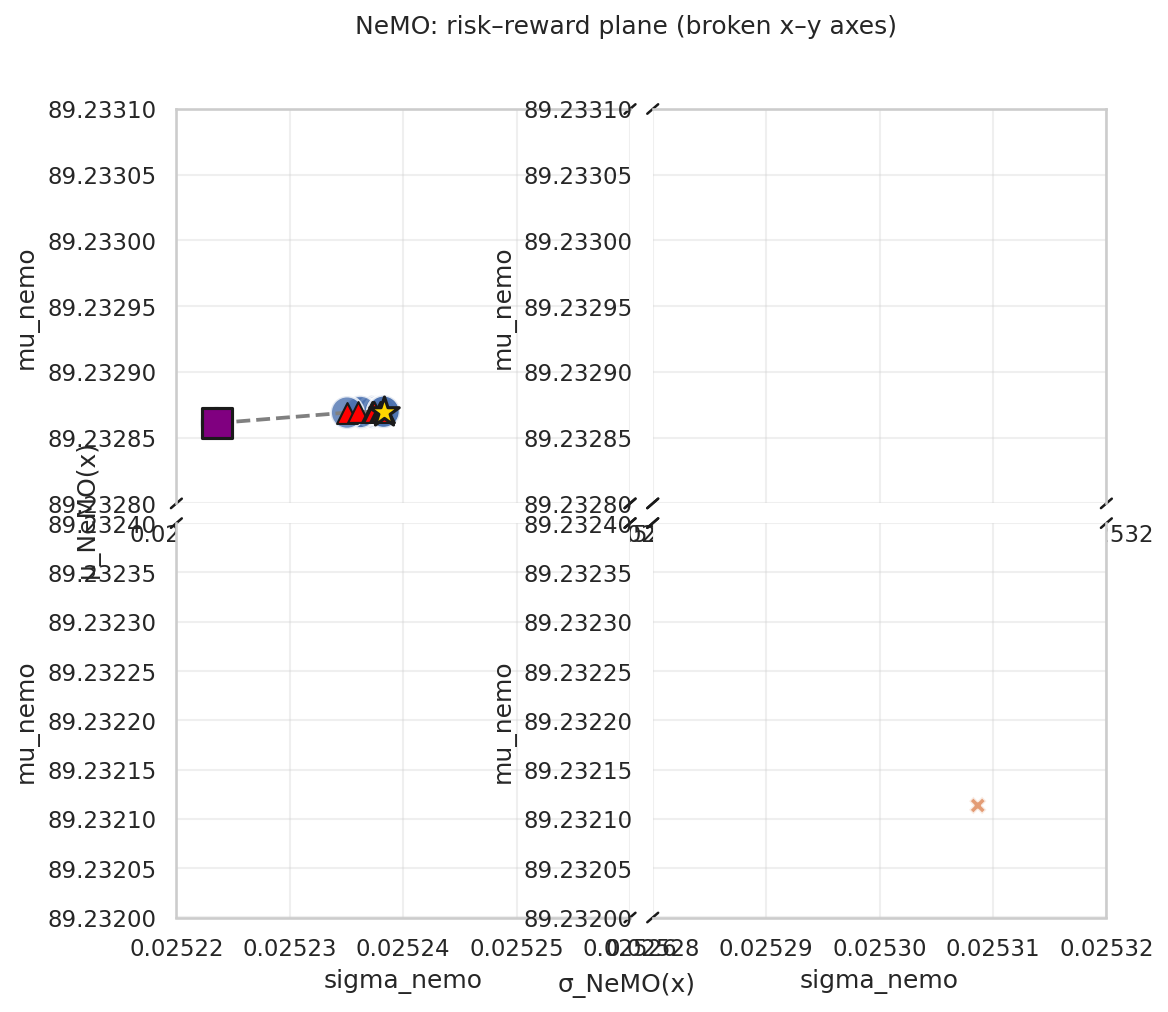

Frontier size (NeMO): 10


,model_origin,decision_type,mu_nemo,sigma_nemo,NeMO_lcb,ood_distance
2,GP baseline,gradient_ascent,89.232861,0.025224,89.207638,0.159469
19,GP baseline,gradient_ascent,89.232869,0.025235,89.207634,0.159309
10,GP baseline,gradient_ascent,89.232870,0.025236,89.207634,0.159230
9,GP baseline,gradient_ascent,89.232870,0.025237,89.207632,0.159277
4,GP baseline,gradient_ascent,89.232870,0.025237,89.207632,0.159252
5,GP baseline,gradient_ascent,89.232870,0.025237,89.207632,0.159251
15,GP baseline,gradient_ascent,89.232870,0.025238,89.207632,0.159240
3,GP baseline,gradient_ascent,89.232870,0.025238,89.207632,0.159238
8,GP baseline,gradient_ascent,89.232870,0.025238,89.207632,0.159237
16,GP baseline,gradient_ascent,89.232870,0.025238,89.207631,0.159238



NeMO risk-neutral candidate:


,16
model_origin,GP baseline
decision_type,gradient_ascent
mu_nemo,89.23287
sigma_nemo,0.025238
NeMO_lcb,89.207631
A,0.71192
B,0.603792
C,0.188203
D,0.815132
E,0.403737



NeMO risk-averse candidate:


,2
model_origin,GP baseline
decision_type,gradient_ascent
mu_nemo,89.232861
sigma_nemo,0.025224
NeMO_lcb,89.207638
A,0.711918
B,0.603687
C,0.188452
D,0.815067
E,0.403966


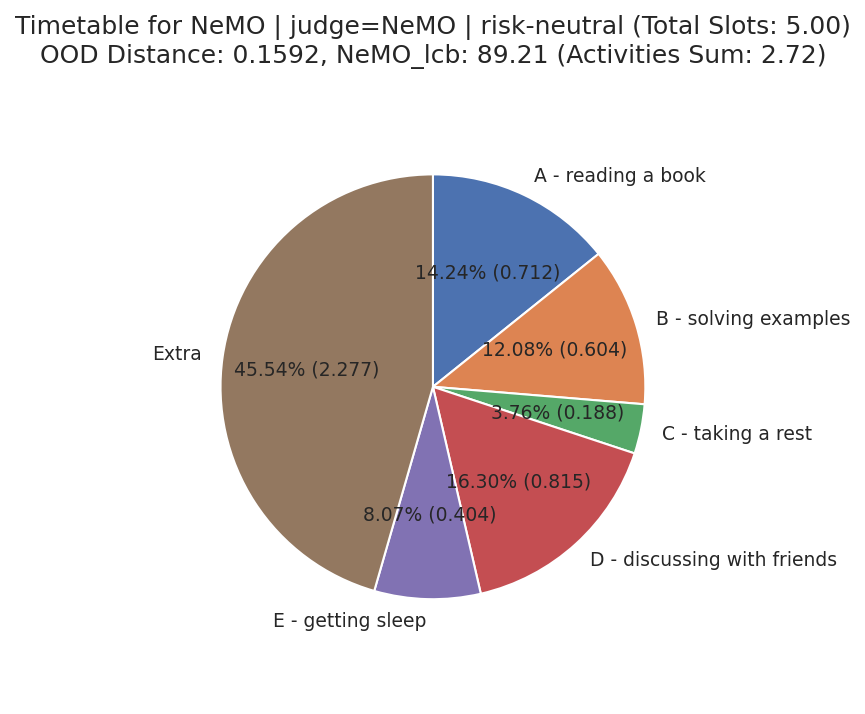

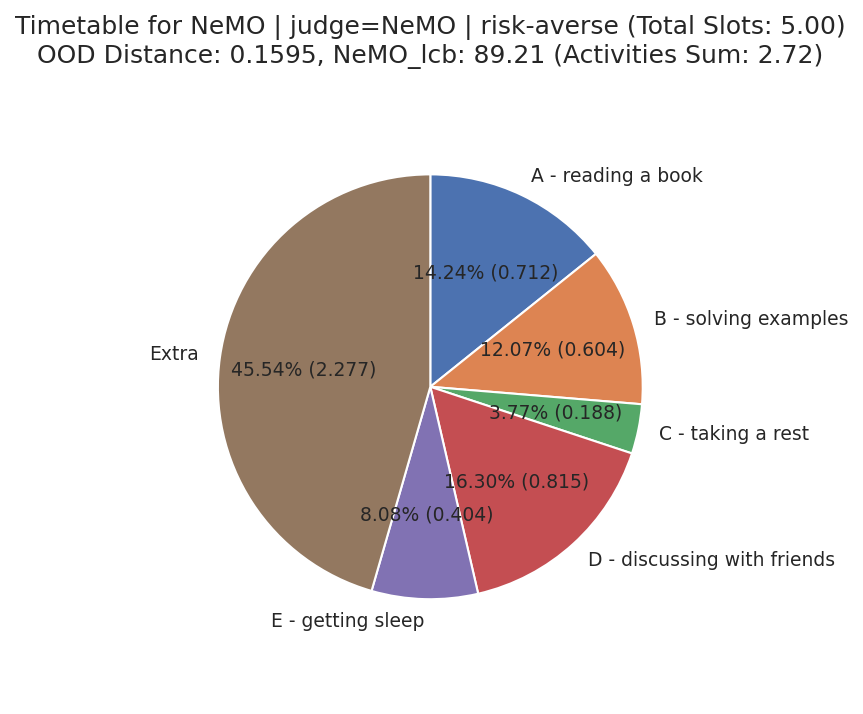


=== RoMA judge: risk–reward plane and efficient frontier ===


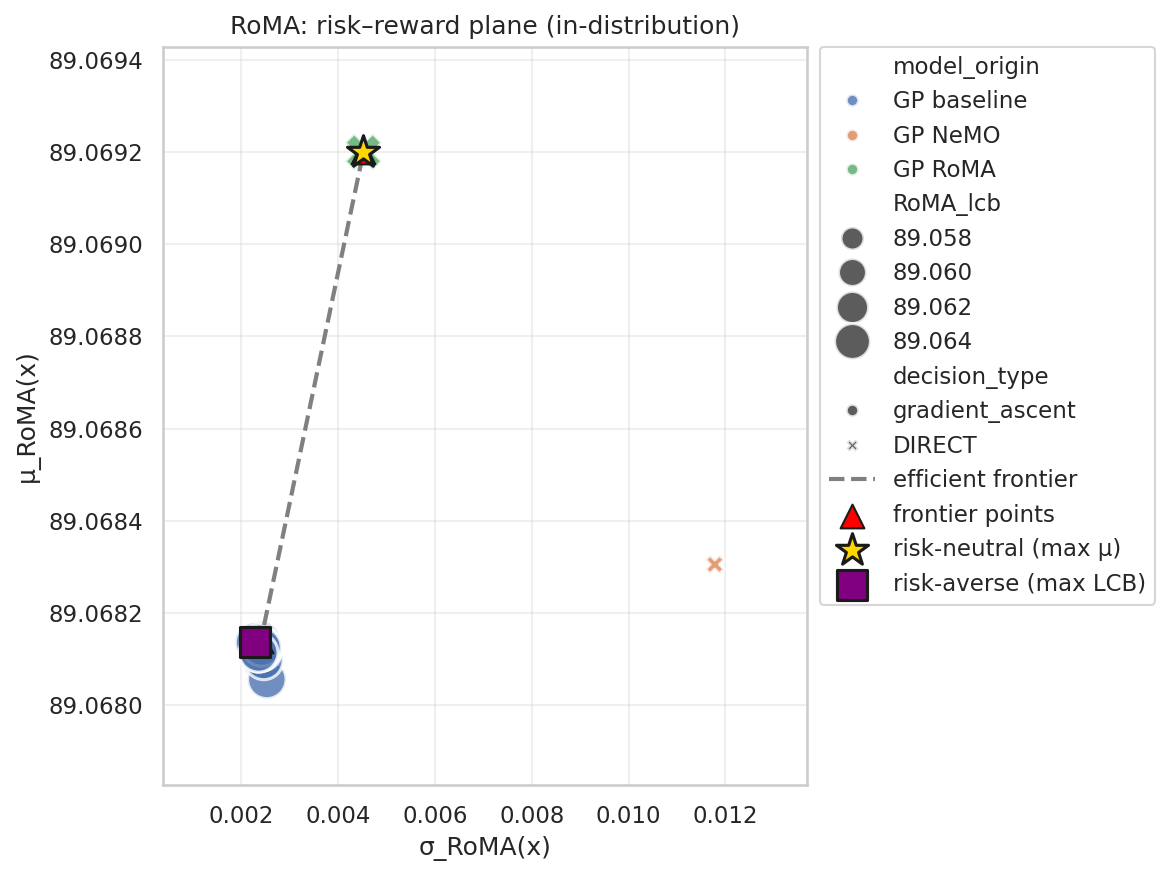

/tmp/ipython-input-376492130.py:317: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0.05, 0.05, 0.95, 0.93))


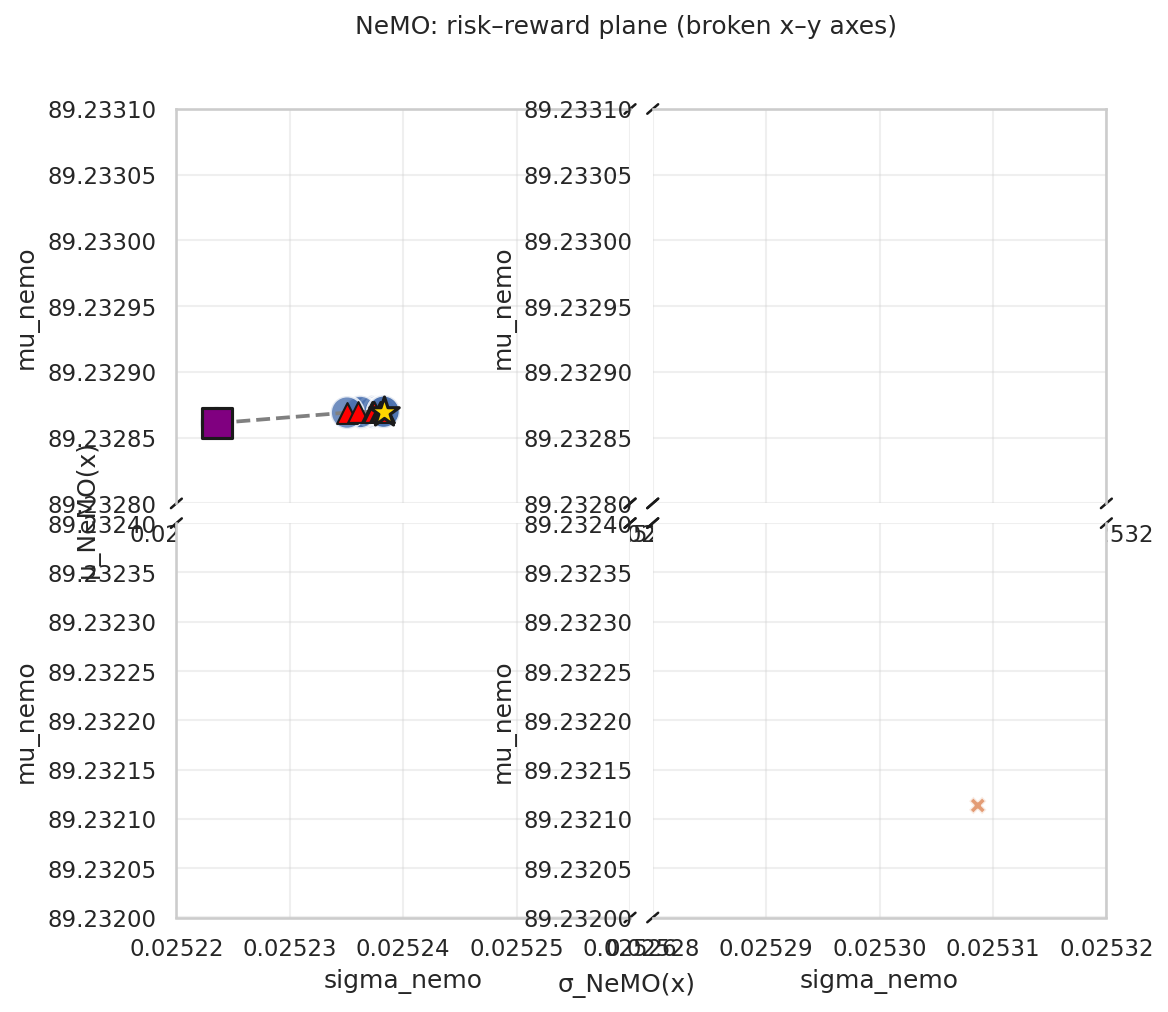

Frontier size (RoMA): 3


,model_origin,decision_type,mu_roma,sigma_roma,RoMA_lcb,ood_distance
2,GP baseline,gradient_ascent,89.068135,0.002278,89.065858,0.159469
0,GP baseline,gradient_ascent,89.068139,0.002401,89.065739,0.159262
21,GP RoMA,DIRECT,89.069201,0.004521,89.064680,0.159903



RoMA risk-neutral candidate:


,21
model_origin,GP RoMA
decision_type,DIRECT
mu_roma,89.069201
sigma_roma,0.004521
RoMA_lcb,89.06468
A,0.71262
B,0.604252
C,0.187243
D,0.814129
E,0.403978



RoMA risk-averse candidate:


,2
model_origin,GP baseline
decision_type,gradient_ascent
mu_roma,89.068135
sigma_roma,0.002278
RoMA_lcb,89.065858
A,0.711918
B,0.603687
C,0.188452
D,0.815067
E,0.403966


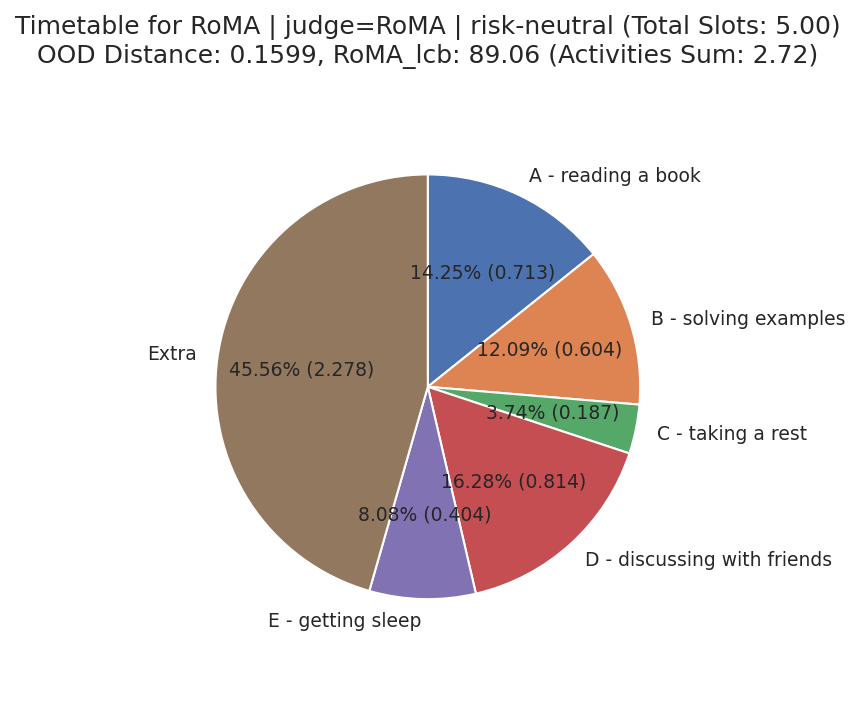

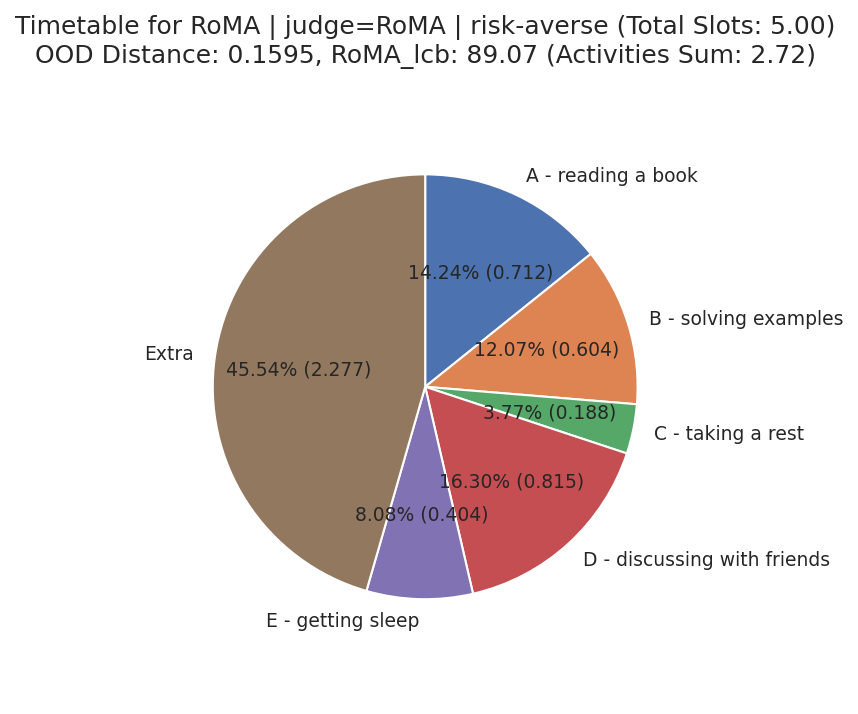


=== COMs judge: risk–reward plane and efficient frontier ===


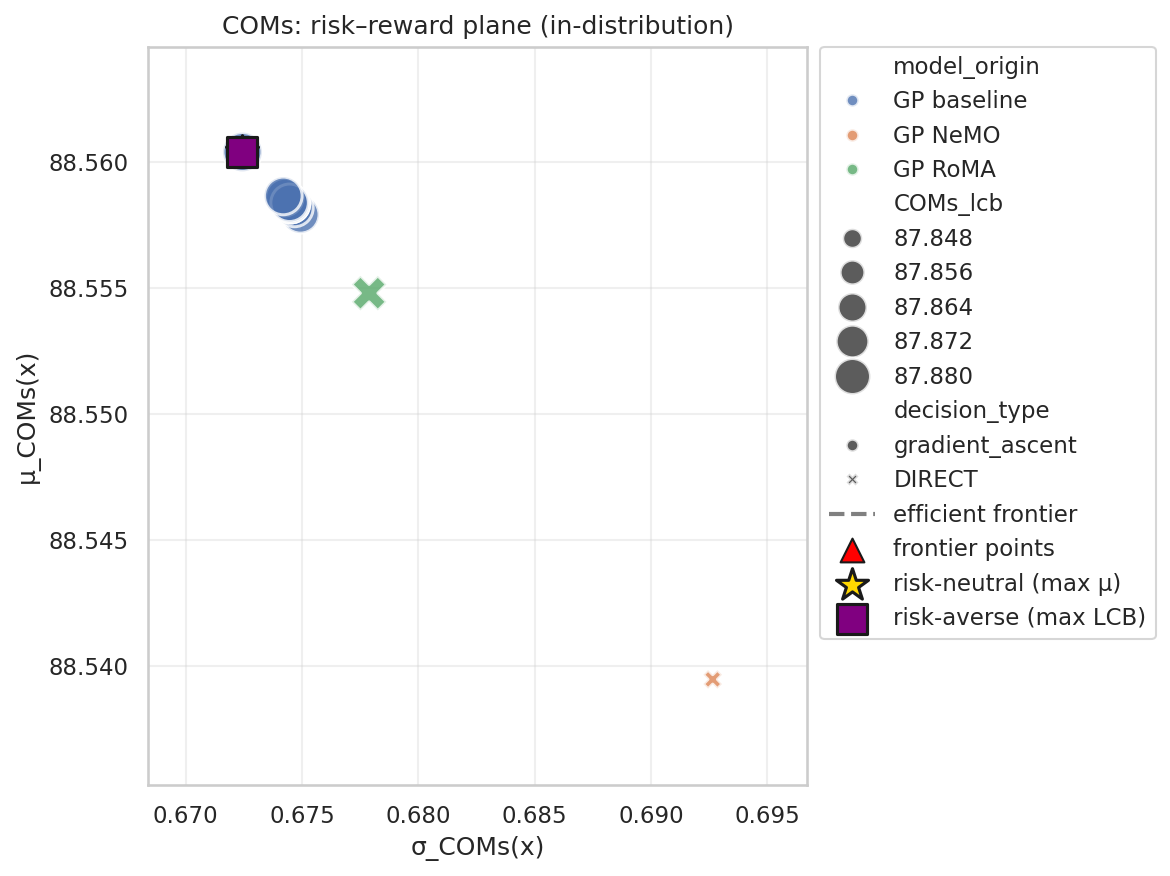

/tmp/ipython-input-376492130.py:317: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0.05, 0.05, 0.95, 0.93))


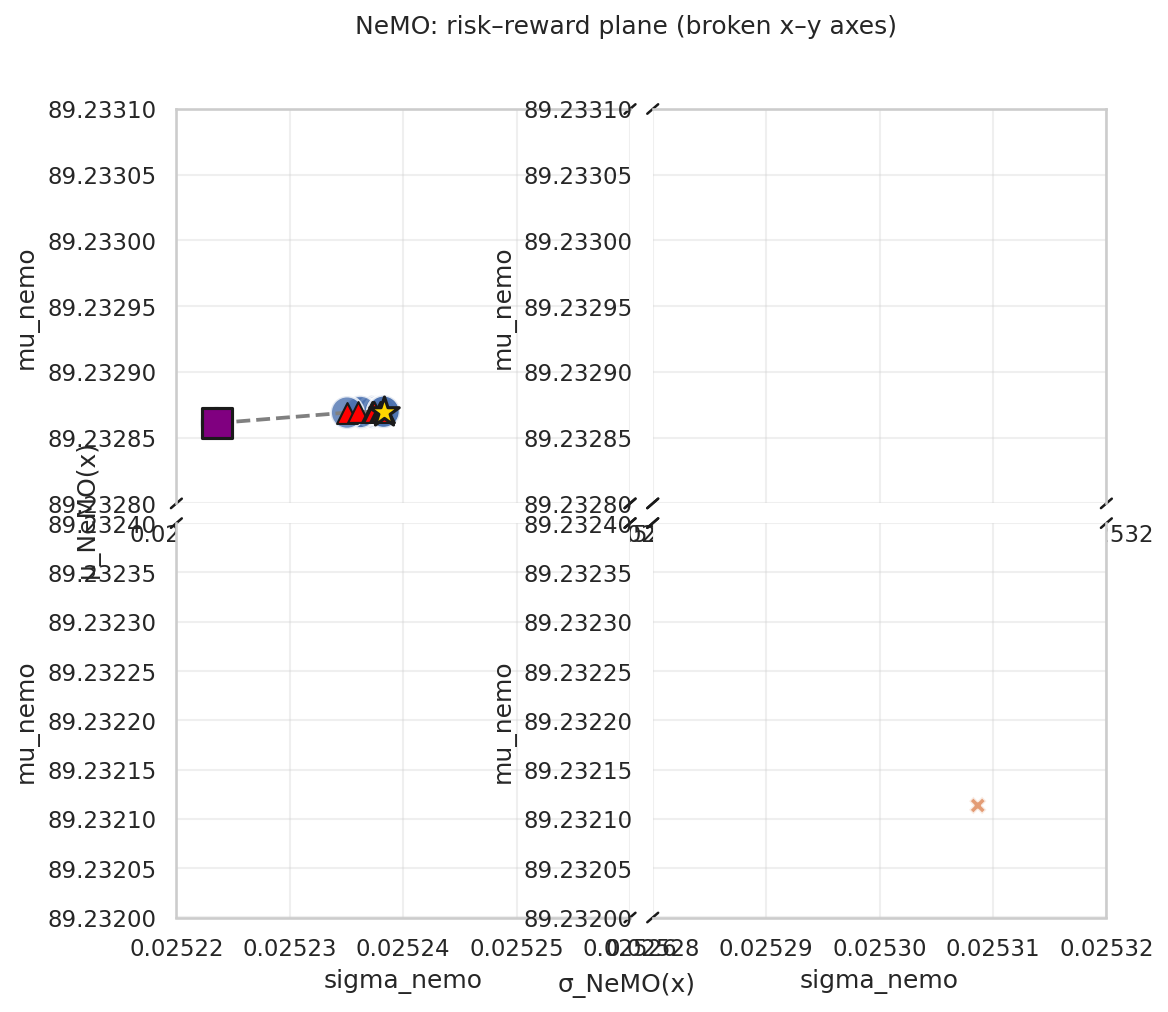

Frontier size (COMs): 1


,model_origin,decision_type,mu_coms,sigma_coms,COMs_lcb,ood_distance
2,GP baseline,gradient_ascent,88.560418,0.672443,87.887975,0.159469



COMs risk-neutral candidate:


,2
model_origin,GP baseline
decision_type,gradient_ascent
mu_coms,88.560418
sigma_coms,0.672443
COMs_lcb,87.887975
A,0.711918
B,0.603687
C,0.188452
D,0.815067
E,0.403966



COMs risk-averse candidate:


,2
model_origin,GP baseline
decision_type,gradient_ascent
mu_coms,88.560418
sigma_coms,0.672443
COMs_lcb,87.887975
A,0.711918
B,0.603687
C,0.188452
D,0.815067
E,0.403966


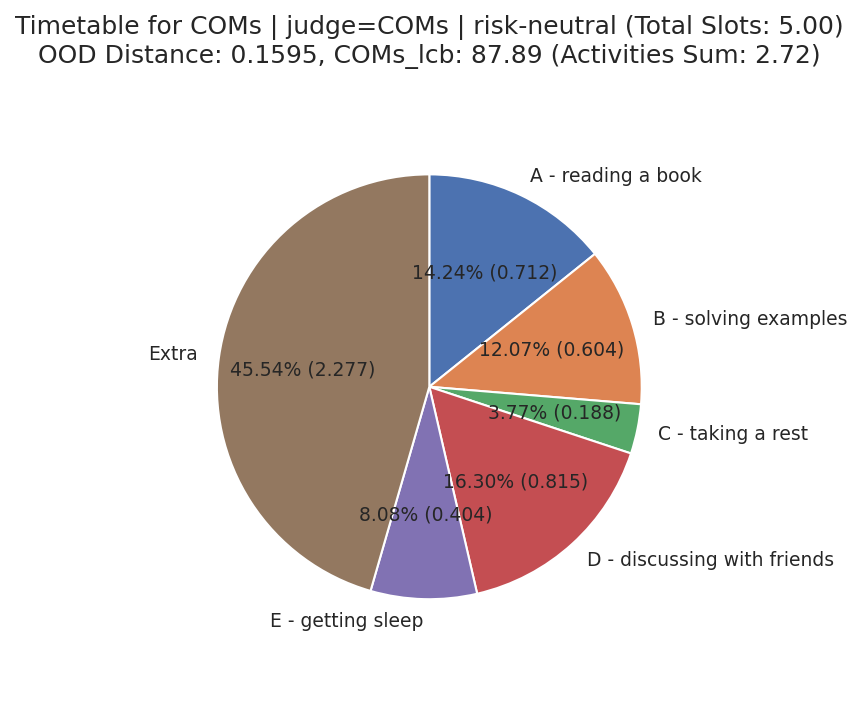

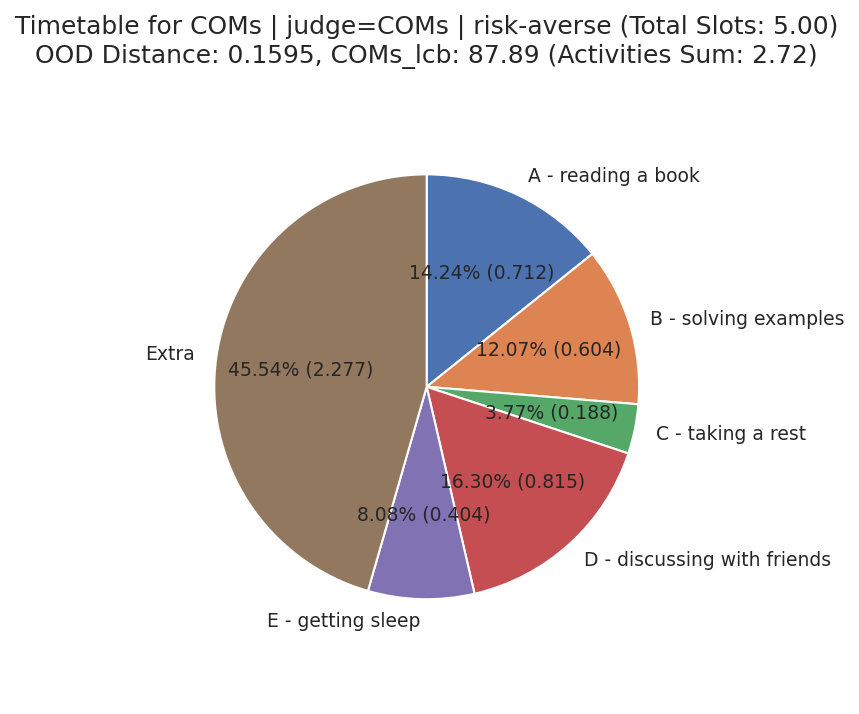

In [96]:
# Cell 8-2 – Efficient frontier, μ–σ plots, pies for RN / RA candidates

# 7) Efficient frontier utilities
def efficient_frontier(df, mu_col, sigma_col):
    """
    Return non-dominated points in (sigma, mu):
    lower sigma & higher mu is better.
    """
    pts = df[[sigma_col, mu_col]].to_numpy()
    order = np.argsort(pts[:, 0])  # by sigma ascending

    frontier_pos = []
    best_mu = -np.inf
    for pos in order:
        sigma, mu = pts[pos]
        if mu > best_mu + 1e-10:
            frontier_pos.append(pos)
            best_mu = mu

    # pos는 df 내부의 위치이므로 iloc 사용 (원본 index 유지)
    return df.iloc[frontier_pos].copy()

from matplotlib.ticker import ScalarFormatter

def plot_mu_sigma_plane(df, mu_col, sigma_col, judge_name,
                        lcb_col=None, score_col=None,
                        best_offline_score=None):

    # 해상도, 크기 조금 키우기
    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

    # --- 전체 후보 scatter ---
    # 색: model_origin, 모양: decision_type (DIRECT vs gradient_ascent)
    if score_col is not None and score_col in df.columns:
        sns.scatterplot(
            data=df,
            x=sigma_col,
            y=mu_col,
            hue="model_origin",
            style="decision_type",
            size=score_col,
            sizes=(80, 350),      # 점 더 크게
            alpha=0.8,
            ax=ax,
        )
    else:
        sns.scatterplot(
            data=df,
            x=sigma_col,
            y=mu_col,
            hue="model_origin",
            style="decision_type",
            s=120,                # 기본 크기 키우기
            alpha=0.8,
            ax=ax,
        )

    # --- efficient frontier 계산 ---
    frontier = efficient_frontier(df, mu_col, sigma_col)

    # 점선으로 frontier 연결
    ax.plot(
        frontier[sigma_col],
        frontier[mu_col],
        linestyle="--",
        linewidth=2.0,
        color="gray",
        label="efficient frontier",
        zorder=3,
    )

    # frontier 위의 점(붉은 삼각형)
    ax.scatter(
        frontier[sigma_col],
        frontier[mu_col],
        marker="^",
        s=130,
        color="red",
        edgecolor="k",
        linewidth=1.0,
        label="frontier points",
        zorder=4,
    )

    # --- frontier 중에서 risk-neutral / risk-averse 선택 ---
    # Risk-neutral: frontier에서 mu 최대
    rn_idx = frontier[mu_col].idxmax()
    rn_row = df.loc[rn_idx]

    # Risk-averse: frontier에서 LCB 최대 (보수적 criterion)
    if lcb_col is not None and lcb_col in frontier.columns:
        ra_idx = frontier[lcb_col].idxmax()
    else:
        ra_idx = frontier[sigma_col].idxmin()
    ra_row = df.loc[ra_idx]

    # risk-neutral: 금색 별
    ax.scatter(
        rn_row[sigma_col],
        rn_row[mu_col],
        marker="*", s=260,
        color="gold",
        edgecolor="k",
        linewidth=1.5,
        label="risk-neutral (max μ)",
        zorder=5,
    )

    # risk-averse: 보라색 네모
    ax.scatter(
        ra_row[sigma_col],
        ra_row[mu_col],
        marker="s", s=220,
        color="purple",
        edgecolor="k",
        linewidth=1.5,
        label="risk-averse (max LCB)",
        zorder=5,
    )

    # --- 축 포맷 예쁘게 (과학적 표기 + offset 제거) ---
    ax.ticklabel_format(style="plain", axis="both")
    for axis in [ax.xaxis, ax.yaxis]:
        formatter = ScalarFormatter(useOffset=False, useMathText=False)
        axis.set_major_formatter(formatter)

    # --- 축에 margin 조금 주기 (너무 붙어 있는 느낌 방지) ---
    x_vals = df[sigma_col].to_numpy()
    y_vals = df[mu_col].to_numpy()
    dx = (x_vals.max() - x_vals.min()) or 1e-4
    dy = (y_vals.max() - y_vals.min()) or 1e-4
    ax.set_xlim(x_vals.min() - 0.2 * dx, x_vals.max() + 0.2 * dx)
    ax.set_ylim(y_vals.min() - 0.2 * dy, y_vals.max() + 0.2 * dy)

    ax.set_xlabel(f"σ_{judge_name}(x)")
    ax.set_ylabel(f"μ_{judge_name}(x)")
    ax.set_title(f"{judge_name}: risk–reward plane (in-distribution)")

    ax.grid(True, alpha=0.3)

    # legend를 오른쪽 밖으로 빼서 안 겹치게
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    fig.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import ScalarFormatter

def plot_mu_sigma_plane_broken_xy(
    df,
    mu_col,
    sigma_col,
    judge_name,
    lcb_col=None,
    score_col=None,
    x_ranges=None,   # [(x_low_min, x_low_max), (x_high_min, x_high_max)]
    y_ranges=None,   # [(y_low_min, y_low_max), (y_high_min, y_high_max)]
):
    """
    σ–μ plane을 x, y 모두 브로큰(broken) 축으로 시각화하는 함수.
    좌하–우하–좌상–우상 네 개의 축으로 클러스터와 아웃라이어를 모두 보여준다.
    """

    # === 데이터 준비 ===
    frontier = efficient_frontier(df, mu_col, sigma_col)
    rn_idx = frontier[mu_col].idxmax()
    rn_row = df.loc[rn_idx]
    if lcb_col is not None and lcb_col in frontier.columns:
        ra_idx = frontier[lcb_col].idxmax()
    else:
        ra_idx = frontier[sigma_col].idxmin()
    ra_row = df.loc[ra_idx]

    x_vals = df[sigma_col].to_numpy()
    y_vals = df[mu_col].to_numpy()

    # === 범위 자동 계산 ===
    if x_ranges is None:
        # 전체 분포 기준으로 아래쪽 클러스터, 위쪽 아웃라이어로 분리
        x_sorted = np.sort(x_vals)
        x_ranges = [
            (x_sorted.min(), np.quantile(x_vals, 0.25)),
            (np.quantile(x_vals, 0.75), x_sorted.max()),
        ]
    if y_ranges is None:
        y_sorted = np.sort(y_vals)
        y_ranges = [
            (y_sorted.min(), np.quantile(y_vals, 0.25)),
            (np.quantile(y_vals, 0.75), y_sorted.max()),
        ]

    # === 2x2 broken 축 만들기 ===
    fig, axes = plt.subplots(
        2, 2,
        figsize=(8, 7),
        dpi=150,
        sharex=False,
        sharey=False,
        gridspec_kw={'hspace': 0.05, 'wspace': 0.05}
    )

    # flatten
    axs = axes.flatten()

    # --- 각 축 그리기 ---
    for ax in axs:
        if score_col is not None and score_col in df.columns:
            sns.scatterplot(
                data=df,
                x=sigma_col,
                y=mu_col,
                hue="model_origin",
                style="decision_type",
                size=score_col,
                sizes=(70, 250),
                alpha=0.8,
                ax=ax,
                legend=False
            )
        else:
            sns.scatterplot(
                data=df,
                x=sigma_col,
                y=mu_col,
                hue="model_origin",
                style="decision_type",
                s=100,
                alpha=0.8,
                ax=ax,
                legend=False
            )

        ax.plot(
            frontier[sigma_col],
            frontier[mu_col],
            linestyle="--",
            linewidth=1.8,
            color="gray",
            zorder=3
        )
        ax.scatter(
            frontier[sigma_col],
            frontier[mu_col],
            marker="^",
            s=100,
            color="red",
            edgecolor="k",
            linewidth=1.0,
            zorder=4,
        )
        ax.scatter(
            rn_row[sigma_col],
            rn_row[mu_col],
            marker="*", s=220,
            color="gold",
            edgecolor="k",
            linewidth=1.5,
            zorder=5,
        )
        ax.scatter(
            ra_row[sigma_col],
            ra_row[mu_col],
            marker="s", s=200,
            color="purple",
            edgecolor="k",
            linewidth=1.5,
            zorder=5,
        )

        ax.ticklabel_format(style="plain", axis="both")
        for axis in [ax.xaxis, ax.yaxis]:
            formatter = ScalarFormatter(useOffset=False, useMathText=False)
            axis.set_major_formatter(formatter)
        ax.grid(True, alpha=0.3)

    # === 범위 설정 ===
    # 좌하 / 우하 / 좌상 / 우상
    (xlow, xhigh), (x2low, x2high) = x_ranges
    (ylow, yhigh), (y2low, y2high) = y_ranges

    axes[1,0].set_xlim(xlow, xhigh)
    axes[1,1].set_xlim(x2low, x2high)
    axes[0,0].set_xlim(xlow, xhigh)
    axes[0,1].set_xlim(x2low, x2high)

    axes[1,0].set_ylim(ylow, yhigh)
    axes[1,1].set_ylim(ylow, yhigh)
    axes[0,0].set_ylim(y2low, y2high)
    axes[0,1].set_ylim(y2low, y2high)

    # === 브로큰 표시용 대각선 ===
    d = .012
    kwargs = dict(color='k', clip_on=False, lw=1.2)
    # x축 브로큰
    for ax_row in axes:
        ax_row[0].spines.right.set_visible(False)
        ax_row[1].spines.left.set_visible(False)
        ax_row[0].plot((1 - d, 1 + d), (-d, +d), transform=ax_row[0].transAxes, **kwargs)
        ax_row[0].plot((1 - d, 1 + d), (1 - d, 1 + d), transform=ax_row[0].transAxes, **kwargs)
        ax_row[1].plot((-d, +d), (-d, +d), transform=ax_row[1].transAxes, **kwargs)
        ax_row[1].plot((-d, +d), (1 - d, 1 + d), transform=ax_row[1].transAxes, **kwargs)
    # y축 브로큰
    for ax_col in axes.T:
        ax_col[1].spines.top.set_visible(False)
        ax_col[0].spines.bottom.set_visible(False)
        ax_col[1].plot((-d, +d), (1 - d, 1 + d), transform=ax_col[1].transAxes, **kwargs)
        ax_col[1].plot((1 - d, 1 + d), (1 - d, 1 + d), transform=ax_col[1].transAxes, **kwargs)
        ax_col[0].plot((-d, +d), (-d, +d), transform=ax_col[0].transAxes, **kwargs)
        ax_col[0].plot((1 - d, 1 + d), (-d, +d), transform=ax_col[0].transAxes, **kwargs)

    # === 라벨 및 제목 ===
    fig.text(0.5, 0.04, f"σ_{judge_name}(x)", ha="center")
    fig.text(0.04, 0.5, f"μ_{judge_name}(x)", va="center", rotation="vertical")
    fig.suptitle(f"{judge_name}: risk–reward plane (broken x–y axes)", fontsize=12, y=0.97)
    fig.tight_layout(rect=(0.05, 0.05, 0.95, 0.93))
    plt.show()

def plot_pie_timetable(row,
                       judge_name,
                       risk_label,          # 'risk-neutral' or 'risk-averse'
                       features_short,
                       features_long,
                       lcb_col=None,        # e.g. 'NeMO_lcb', 'RoMA_lcb', ...
                       total_budget=5.0):

    # 활동 값 + Extra 계산
    values = row[features_short].astype(float).to_numpy()
    sum_activities = values.sum()
    extra = max(0.0, total_budget - sum_activities)

    plot_values = list(values) + [extra]
    labels = list(features_long) + ["Extra"]

    # autopct 커스텀: XX.XX% (value)
    def make_autopct(values):
        def _autopct(pct):
            total = sum(values)
            val = pct * total / 100.0
            # 퍼센트는 소수 둘째 자리까지, 값은 3자리 정도
            return f"{pct:.2f}% ({val:.3f})"
        return _autopct

    plt.figure(figsize=(5, 5), dpi=150)
    wedges, texts, autotexts = plt.pie(
        plot_values,
        labels=labels,
        autopct=make_autopct(plot_values),
        startangle=90,
        counterclock=False,
    )

    # 글씨 크기 조금 키우기
    for t in texts:
        t.set_fontsize(9)
    for t in autotexts:
        t.set_fontsize(9)

    # 제목 구성: judge, risk-type, OOD, LCB, 활동 합
    lcb_text = ""
    if lcb_col is not None and (lcb_col in row.index):
        lcb_text = f", {lcb_col}: {row[lcb_col]:.2f}"

    title = (
        f"Timetable for {judge_name} | judge={judge_name} | {risk_label} "
        f"(Total Slots: {total_budget:.2f})\n"
        f"OOD Distance: {row['ood_distance']:.4f}{lcb_text} "
        f"(Activities Sum: {sum_activities:.2f})"
    )

    plt.title(title)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

# 8) Judge별 μ–σ plane + frontier + RN/RA timetable pies
final_candidates = []  # risk-neutral / risk-averse per judge를 모아둘 리스트

for judge_name, mu_col, sigma_col, lcb_col in [
    ("NeMO", "mu_nemo", "sigma_nemo", "NeMO_lcb"),
    ("RoMA", "mu_roma", "sigma_roma", "RoMA_lcb"),
    ("COMs", "mu_coms", "sigma_coms", "COMs_lcb"),
]:
    print(f"\n=== {judge_name} judge: risk–reward plane and efficient frontier ===")
    plot_mu_sigma_plane(
        decision_id_df,
        mu_col,
        sigma_col,
        judge_name,
        lcb_col=lcb_col,
        score_col=lcb_col,
    )
    plot_mu_sigma_plane_broken_xy(
    decision_id_df,
    mu_col="mu_nemo",
    sigma_col="sigma_nemo",
    judge_name="NeMO",
    lcb_col="NeMO_lcb",
    score_col="NeMO_lcb",
    # 직접 범위 지정
    x_ranges=[(0.02522, 0.02526), (0.02528, 0.02532)],
    y_ranges=[(89.2320, 89.2324), (89.2328, 89.2331)],
)

    front_df = efficient_frontier(decision_id_df, mu_col, sigma_col)
    print(f"Frontier size ({judge_name}):", len(front_df))
    display(front_df[["model_origin", "decision_type", mu_col, sigma_col, lcb_col, "ood_distance"]])

    # Risk-neutral: max mu on frontier
    rn_idx = front_df[mu_col].idxmax()
    risk_neutral = front_df.loc[rn_idx].copy()
    risk_neutral["judge"] = judge_name
    risk_neutral["risk_type"] = "risk_neutral"

    # Risk-averse: max LCB on frontier
    ra_idx = front_df[lcb_col].idxmax()
    risk_averse = front_df.loc[ra_idx].copy()
    risk_averse["judge"] = judge_name
    risk_averse["risk_type"] = "risk_averse"

    final_candidates.append(risk_neutral)
    final_candidates.append(risk_averse)

    print(f"\n{judge_name} risk-neutral candidate:")
    display(risk_neutral[["model_origin", "decision_type", mu_col, sigma_col, lcb_col] + features])

    print(f"\n{judge_name} risk-averse candidate:")
    display(risk_averse[["model_origin", "decision_type", mu_col, sigma_col, lcb_col] + features])

        # Pie plots
    features_short = features
    features_long = [
        'A - reading a book',
        'B - solving examples',
        'C - taking a rest',
        'D - discussing with friends',
        'E - getting sleep',
    ]

    # risk-neutral
    plot_pie_timetable(
        risk_neutral,
        judge_name=judge_name,
        risk_label="risk-neutral",
        features_short=features_short,
        features_long=features_long,
        lcb_col=lcb_col,          # 해당 judge의 LCB 사용
        total_budget=5.0,
    )

    # risk-averse
    plot_pie_timetable(
        risk_averse,
        judge_name=judge_name,
        risk_label="risk-averse",
        features_short=features_short,
        features_long=features_long,
        lcb_col=lcb_col,
        total_budget=5.0,
    )


In [97]:
# Cell 8-3 – Export risk-neutral / risk-averse candidates (per judge)

final_candidates_df = pd.DataFrame(final_candidates)

print("\n=== Final candidates (risk-neutral / risk-averse per judge) ===")
display_cols = [
    "judge",
    "risk_type",
    "model_origin",
    "decision_type",
    "ood_distance",
    "mu_nemo", "sigma_nemo",
    "mu_roma", "sigma_roma",
    "mu_coms", "sigma_coms",
    "NeMO_lcb", "RoMA_lcb", "COMs_lcb",
] + features
display_cols = [c for c in display_cols if c in final_candidates_df.columns]
display(final_candidates_df[display_cols])

# 1) 제출용 query.csv: decision 변수 A~E만 포함
query_df = final_candidates_df[features].copy()
query_csv_path = "query.csv"
query_df.to_csv(query_csv_path, index=False)
print(f"Saved risk-neutral / risk-averse candidates to '{query_csv_path}' (A~E only).")

# 2) 선택: 메타 정보까지 포함한 엑셀 저장 (TA 분석용)
meta_excel_path = "final_candidates_with_meta.xlsx"
final_candidates_df.to_excel(meta_excel_path, index=False)
print(f"Saved full candidate info to '{meta_excel_path}'.")

# optional:  top-k per model by NeMO LCB
# def top_k_per_model(df, score_col='NeMO_lcb', k=5):
#     df_sorted = df.sort_values(score_col, ascending=False)
#     best = df_sorted.groupby('model_origin').head(k).copy()
#     return best
#
# best_per_model = top_k_per_model(decision_id_df, score_col='NeMO_lcb', k=5)
# print('\n=== Top-5 candidates per model (by NeMO LCB) ===')
# display(best_per_model[['model_origin', 'decision_type', 'NeMO_lcb', 'ood_distance'] + features])
# best_per_model.to_excel('best_candidates_by_model.xlsx', index=False)



=== Final candidates (risk-neutral / risk-averse per judge) ===


,judge,risk_type,model_origin,decision_type,ood_distance,mu_nemo,sigma_nemo,mu_roma,sigma_roma,mu_coms,sigma_coms,NeMO_lcb,RoMA_lcb,COMs_lcb,A,B,C,D,E
16,NeMO,risk_neutral,GP baseline,gradient_ascent,0.159238,89.232870,0.025238,89.068122,0.002430,88.558344,0.674526,89.207631,89.065691,87.883818,0.711920,0.603792,0.188203,0.815132,0.403737
2,NeMO,risk_averse,GP baseline,gradient_ascent,0.159469,89.232861,0.025224,89.068135,0.002278,88.560418,0.672443,89.207638,89.065858,87.887975,0.711918,0.603687,0.188452,0.815067,0.403966
21,RoMA,risk_neutral,GP RoMA,DIRECT,0.159903,89.232695,0.025269,89.069201,0.004521,88.554806,0.677889,89.207426,89.064680,87.876917,0.712620,0.604252,0.187243,0.814129,0.403978
2,RoMA,risk_averse,GP baseline,gradient_ascent,0.159469,89.232861,0.025224,89.068135,0.002278,88.560418,0.672443,89.207638,89.065858,87.887975,0.711918,0.603687,0.188452,0.815067,0.403966
2,COMs,risk_neutral,GP baseline,gradient_ascent,0.159469,89.232861,0.025224,89.068135,0.002278,88.560418,0.672443,89.207638,89.065858,87.887975,0.711918,0.603687,0.188452,0.815067,0.403966
2,COMs,risk_averse,GP baseline,gradient_ascent,0.159469,89.232861,0.025224,89.068135,0.002278,88.560418,0.672443,89.207638,89.065858,87.887975,0.711918,0.603687,0.188452,0.815067,0.403966


Saved risk-neutral / risk-averse candidates to 'query.csv' (A~E only).
Saved full candidate info to 'final_candidates_with_meta.xlsx'.
